# Flux Vision Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl 
import seaborn as sns
# sns.set()
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import geoplot as gpl
import json
import mapclassify


%matplotlib inline

In [8]:
# reading the csv file
df = pd.read_csv('../../data/Zoning Province/Flux_24h.csv',sep = ';')
# Filter data with 3h of immobility and exclude `Hors_Zone`
df = df[(df.Immobility == '3h') & (df.Origin != 'Hors_Zone') & (df.Destination != 'Hors_Zone')]
df

Date      Origin  Destination Immobility  \
2       2020-02-01    Bas-Uele    Haut-Uele         3h   
7       2020-02-01    Bas-Uele       Tshopo         3h   
8       2020-02-01    Bas-Uele       Tshopo         3h   
9       2020-02-01    Bas-Uele       Tshopo         3h   
10      2020-02-01    Bas-Uele       Tshopo         3h   
...            ...         ...          ...        ...   
215109  2021-01-03    Sud-Kivu    Nord-Kivu         3h   
215110  2021-01-03    Sud-Kivu    Nord-Kivu         3h   
215111  2021-01-03    Sud-Kivu    Nord-Kivu         3h   
215112  2021-01-03    Sud-Kivu    Nord-Kivu         3h   
215114  2021-01-03  Sud-Ubangi  Nord-Ubangi         3h   

                    Home_Category        Activity_Category Observation_Zone  \
2                Outside_Resident  Destination_Zone_Worker      ZoneGlobale   
7                Outside_Resident           Outside_Worker      ZoneGlobale   
8                Outside_Resident       Origin_Zone_Worker      ZoneGlobale   
9       Destination_Zone_Resident  Destination_Zone_Worker      ZoneGlobale   
10           Origin_Zone_Resident       Origin_Zone_Worker      ZoneGlobale   
...                           ...                      ...              ...   
215109  Destination_Zone_Resident       Origin_Zone_Worker      ZoneGlobale   
215110       Origin_Zone_Resident           Outside_Worker      ZoneGlobale   
215111       Origin_Zone_Resident  Destination_Zone_Worker      ZoneGlobale   
215112       Origin_Zone_Resident       Origin_Zone_Worker      ZoneGlobale   
215114           Outside_Resident           Outside_Worker      ZoneGlobale   

             Mode  Volume  
2       All_modes    1049  
7       All_modes    1049  
8       All_modes    1049  
9       All_modes      42  
10      All_modes    1049  
...           ...     ...  
215109  All_modes    4929  
215110  All_modes    1017  
215111  All_modes    2743  
215112  All_modes   16153  
215114  All_modes    1165  

[90114 rows x 9 columns]

In [9]:
# Home_Category occurences 
list((df.groupby(by = 'Home_Category').groups.keys()))

['Destination_Zone_Resident',
 'Origin_Zone_Resident',
 'Outside_Resident',
 'Study_Zone_Resident']

In [10]:
#consider only 'Date','Origin' and 'Destination'
df = df.groupby(by=['Date','Origin','Destination'], as_index=0).sum()
df

Date        Origin    Destination  Volume
0      2020-02-01      Bas-Uele      Haut-Uele    1049
1      2020-02-01      Bas-Uele         Tshopo    3189
2      2020-02-01      Equateur       Kinshasa    4961
3      2020-02-01      Equateur     Sud-Ubangi     505
4      2020-02-01  Haut-Katanga    Haut-Lomami      22
...           ...           ...            ...     ...
20224  2021-01-03     Nord-Kivu       Sud-Kivu   78808
20225  2021-01-03       Sankuru  Kasai-Central    3086
20226  2021-01-03       Sankuru      Nord-Kivu      68
20227  2021-01-03      Sud-Kivu      Nord-Kivu   76879
20228  2021-01-03    Sud-Ubangi    Nord-Ubangi    1165

[20229 rows x 4 columns]

In [11]:
df.head(5)

Date        Origin  Destination  Volume
0  2020-02-01      Bas-Uele    Haut-Uele    1049
1  2020-02-01      Bas-Uele       Tshopo    3189
2  2020-02-01      Equateur     Kinshasa    4961
3  2020-02-01      Equateur   Sud-Ubangi     505
4  2020-02-01  Haut-Katanga  Haut-Lomami      22

In [12]:
df.tail(5)

Date      Origin    Destination  Volume
20224  2021-01-03   Nord-Kivu       Sud-Kivu   78808
20225  2021-01-03     Sankuru  Kasai-Central    3086
20226  2021-01-03     Sankuru      Nord-Kivu      68
20227  2021-01-03    Sud-Kivu      Nord-Kivu   76879
20228  2021-01-03  Sud-Ubangi    Nord-Ubangi    1165

In [13]:
# Date Conversion
df['Date'] = pd.to_datetime(df['Date'])
df['Date_day'] = df['Date'].dt.weekday

## Checking for missing dates

In [14]:
# pd.date_range('2020-01-31','2020-03-17',)
def check_missing_dates(df,start,end):
    return set([d.strftime('%Y-%m-%d') for d in pd.date_range(start,end,)]) - set(df.Date.dt.date.astype(str))

In [16]:
global_misssing_dates = check_missing_dates(df,'2020-02-1','2021-01-04')
global_misssing_dates

{'2020-02-05',
 '2020-02-28',
 '2020-03-02',
 '2020-05-10',
 '2020-05-16',
 '2020-06-30',
 '2020-10-27',
 '2021-01-04'}

In [17]:
#Missing dates per province

missing_dates ={}
for prov in set(df.Destination):
    missing_dates[prov] = check_missing_dates(df[df.Destination == prov],'2020-02-1','2020-08-11') - global_misssing_dates
missing_dates

# 'Haut-Uele', 'Bas-Uele', 'Sud-Ubangi', 'Nord-Ubangi', 'Mongala','Tshuapa', 'Tanganyika', 'Equateur', 'Sankuru'

{'Nord-Kivu': set(),
 'Kwango': {'2020-03-06'},
 'Ituri': set(),
 'Sud-Kivu': set(),
 'Kongo-Central': set(),
 'Kasai': set(),
 'Nord-Ubangi': {'2020-03-04',
  '2020-04-06',
  '2020-04-07',
  '2020-04-08',
  '2020-04-13',
  '2020-04-19',
  '2020-05-24',
  '2020-06-05',
  '2020-06-13',
  '2020-06-14',
  '2020-06-23',
  '2020-06-29',
  '2020-07-05',
  '2020-07-07',
  '2020-07-11',
  '2020-07-12',
  '2020-07-13',
  '2020-07-14',
  '2020-07-20',
  '2020-07-21',
  '2020-07-26',
  '2020-07-31',
  '2020-08-01',
  '2020-08-05',
  '2020-08-06',
  '2020-08-07',
  '2020-08-08',
  '2020-08-10',
  '2020-08-11'},
 'Bas-Uele': {'2020-03-05',
  '2020-03-06',
  '2020-03-08',
  '2020-03-11',
  '2020-03-17',
  '2020-03-18',
  '2020-03-21',
  '2020-03-28',
  '2020-04-05',
  '2020-04-09',
  '2020-04-26',
  '2020-05-06',
  '2020-05-21',
  '2020-05-29',
  '2020-06-02',
  '2020-06-08',
  '2020-06-10',
  '2020-06-12',
  '2020-06-26',
  '2020-06-28',
  '2020-06-29',
  '2020-07-01',
  '2020-07-02',
  '2020-07-04

In [20]:
missing_dates ={}
for prov in set(df.Origin):
    missing_dates[prov] = check_missing_dates(df[df.Origin == prov],'2020-02-1','2021-01-04') - global_misssing_dates
missing_dates

{'Nord-Kivu': set(),
 'Kwango': {'2020-03-06', '2020-07-01', '2020-12-11'},
 'Ituri': {'2020-12-11'},
 'Kongo-Central': set(),
 'Sud-Kivu': set(),
 'Kasai': set(),
 'Nord-Ubangi': {'2020-04-07',
  '2020-04-08',
  '2020-04-11',
  '2020-04-15',
  '2020-04-18',
  '2020-04-21',
  '2020-04-22',
  '2020-04-26',
  '2020-04-30',
  '2020-06-05',
  '2020-06-11',
  '2020-06-14',
  '2020-06-17',
  '2020-06-18',
  '2020-06-21',
  '2020-06-25',
  '2020-07-07',
  '2020-07-10',
  '2020-07-12',
  '2020-07-13',
  '2020-07-17',
  '2020-07-21',
  '2020-07-22',
  '2020-07-25',
  '2020-07-26',
  '2020-07-28',
  '2020-07-29',
  '2020-07-30',
  '2020-07-31',
  '2020-08-01',
  '2020-08-02',
  '2020-08-04',
  '2020-08-06',
  '2020-08-07',
  '2020-08-08',
  '2020-08-09',
  '2020-08-11',
  '2020-08-12',
  '2020-08-14',
  '2020-08-15',
  '2020-08-17',
  '2020-08-18',
  '2020-08-21',
  '2020-08-22',
  '2020-08-23',
  '2020-08-24',
  '2020-08-25',
  '2020-08-28',
  '2020-08-29',
  '2020-08-30',
  '2020-08-31',
  '20

## Checking for null and missing values

In [21]:
df[(df.Volume.isnull())|(df.Volume.isna())]

Empty DataFrame
Columns: [Date, Origin, Destination, Volume, Date_day]
Index: []

In [22]:
df[(df.Date.isnull())|(df.Date.isna())]

Empty DataFrame
Columns: [Date, Origin, Destination, Volume, Date_day]
Index: []

In [23]:
df[(df.Origin.isnull())|(df.Origin.isna())]

Empty DataFrame
Columns: [Date, Origin, Destination, Volume, Date_day]
Index: []

In [24]:
df[(df.Destination.isnull())|(df.Destination.isna())]

Empty DataFrame
Columns: [Date, Origin, Destination, Volume, Date_day]
Index: []

In [25]:
df.describe()

Volume      Date_day
count   20229.000000  20229.000000
mean    11671.387562      2.993574
std     22431.427159      1.978793
min        21.000000      0.000000
25%       193.000000      1.000000
50%      1316.000000      3.000000
75%      9411.000000      5.000000
max    135456.000000      6.000000

## Checking duplicated values

In [26]:
df[df.duplicated()]

Empty DataFrame
Columns: [Date, Origin, Destination, Volume, Date_day]
Index: []

## Total flux visualization

In [27]:
df_total_flux = df.groupby(by=['Date','Date_day'], as_index=0).sum()
df_total_flux['Date_type'] = df_total_flux['Date_day'].apply(lambda x: 'WE' if (x == 5 or x == 6) else 'JO')

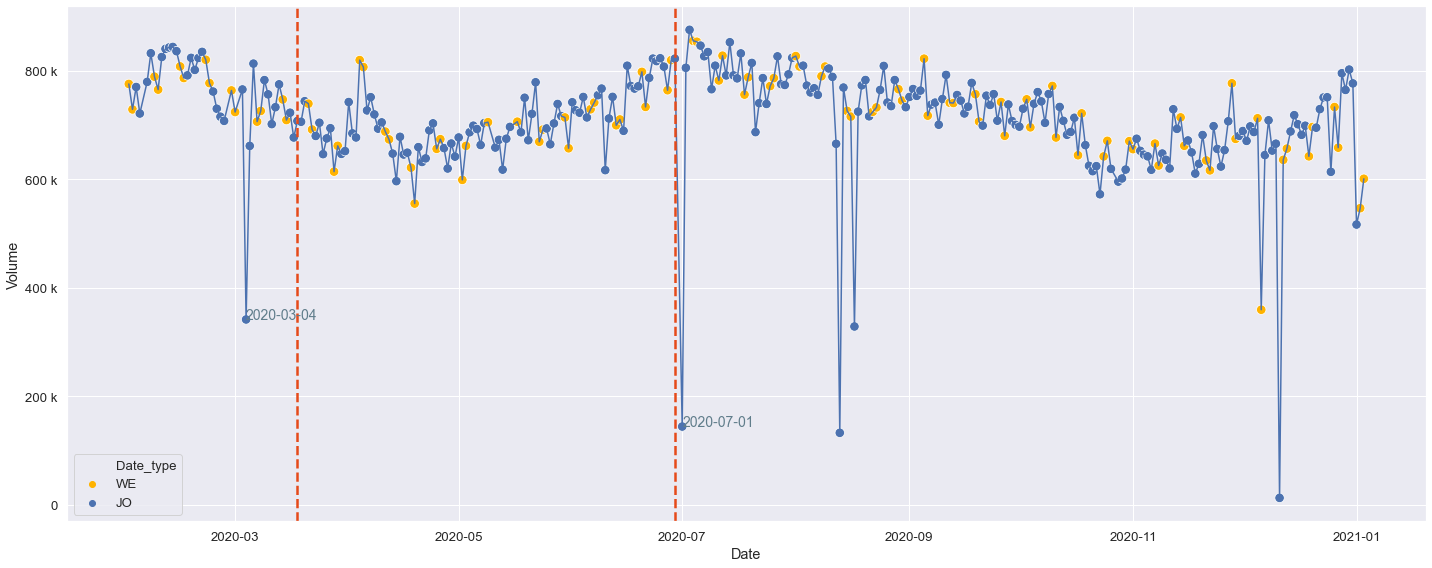

In [28]:
# fig = plt.figure(figsize=(20,10))
# ax = sns.lineplot(x='Date',y='Volume',data=df_total_flux)

# # ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# # ax.
# ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = 'r')
# # ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
# # ax.set_xticklabels(labels=,rotation=45)
# # plt.xlim(0)
# plt.tight_layout()
# plt.show()


fig = plt.figure(figsize=(20,8))
ax = sns.lineplot(x='Date',y='Volume',data=df_total_flux)

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.

sns.scatterplot(x='Date',y='Volume',data=df_total_flux, hue = 'Date_type', ax =ax, palette = ['#ffb300','b'],s = 90)




ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = '#e64a19', ls = '--',lw=2.5)

ax.axvline('2020-06-29',ymin = 0, ymax = 1,color = '#e64a19', ls = '--',lw=2.5)

# ax.axvline('2020-03-04',ymin = 0, ymax = 1,color = '#ffab00', ls = '--')

# ax.axvline('2020-07-01',ymin = 0, ymax = 1,color = '#ffab00', ls = '--')

style = dict(size=14, color='#607d8b')

for d in ['2020-07-01','2020-03-04']:
    ax.text(d,df_total_flux[df_total_flux.Date == d]['Volume'] , d, **style)

# ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)


plt.tight_layout()
plt.show()

In [29]:
# fig = plt.figure(figsize=(30,10))
# ax = sns.barplot(x='Date',y='Volume',data=df_total_flux,palette=['#5DADE2'])

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# # ax.
# # ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = 'r')
# # ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
# # ax.set_xticklabels(labels=,rotation=45)
# # plt.xlim(0)
# plt.tight_layout()
# plt.show()

In [30]:
# df.to_csv('../../data/Flux_24h.csv', sep = ',')

### Origins count and list

In [31]:
len(df.groupby(by = 'Origin').groups.keys())

26

In [32]:
list((df.groupby(by = 'Origin').groups.keys()))

['Bas-Uele',
 'Equateur',
 'Haut-Katanga',
 'Haut-Lomami',
 'Haut-Uele',
 'Ituri',
 'Kasai',
 'Kasai-Central',
 'Kasai-Oriental',
 'Kinshasa',
 'Kongo-Central',
 'Kwango',
 'Kwilu',
 'Lomami',
 'Lualaba',
 'Mai-Ndombe',
 'Maniema',
 'Mongala',
 'Nord-Kivu',
 'Nord-Ubangi',
 'Sankuru',
 'Sud-Kivu',
 'Sud-Ubangi',
 'Tanganyika',
 'Tshopo',
 'Tshuapa']

In [33]:
df['Origin'].value_counts()

Kinshasa          2744
Nord-Kivu         1571
Kasai-Central     1507
Haut-Lomami       1378
Kwilu             1243
Haut-Katanga      1111
Kasai-Oriental    1069
Tshopo            1048
Lomami            1015
Kasai              987
Ituri              870
Lualaba            723
Kwango             671
Sud-Kivu           668
Maniema            637
Tanganyika         514
Mai-Ndombe         433
Kongo-Central      352
Sud-Ubangi         331
Haut-Uele          290
Sankuru            267
Nord-Ubangi        234
Bas-Uele           229
Equateur           162
Mongala            136
Tshuapa             39
Name: Origin, dtype: int64

### Destination count and list

In [34]:
len(df.groupby(by = 'Destination').groups.keys())

26

In [35]:
list((df.groupby(by = 'Destination').groups.keys()))

['Bas-Uele',
 'Equateur',
 'Haut-Katanga',
 'Haut-Lomami',
 'Haut-Uele',
 'Ituri',
 'Kasai',
 'Kasai-Central',
 'Kasai-Oriental',
 'Kinshasa',
 'Kongo-Central',
 'Kwango',
 'Kwilu',
 'Lomami',
 'Lualaba',
 'Mai-Ndombe',
 'Maniema',
 'Mongala',
 'Nord-Kivu',
 'Nord-Ubangi',
 'Sankuru',
 'Sud-Kivu',
 'Sud-Ubangi',
 'Tanganyika',
 'Tshopo',
 'Tshuapa']

In [36]:
df['Destination'].value_counts()

Kinshasa          2709
Nord-Kivu         1581
Kasai-Central     1468
Haut-Katanga      1295
Kwilu             1261
Haut-Lomami       1255
Kasai-Oriental    1107
Lomami            1017
Kasai             1012
Tshopo             958
Ituri              895
Sud-Kivu           780
Lualaba            731
Kwango             683
Maniema            607
Mai-Ndombe         439
Tanganyika         405
Kongo-Central      370
Sud-Ubangi         344
Haut-Uele          280
Sankuru            270
Nord-Ubangi        235
Bas-Uele           232
Equateur           144
Mongala            104
Tshuapa             47
Name: Destination, dtype: int64

### Symmetry check 

In [37]:
df[((df['Origin'] == 'Haut-Katanga') & (df['Destination'] == 'Kinshasa'))|((df['Origin'] == 'Kinshasa') & (df['Destination'] == 'Haut-Katanga'))]

Date        Origin   Destination  Volume  Date_day
6     2020-02-01  Haut-Katanga      Kinshasa     421         5
30    2020-02-01      Kinshasa  Haut-Katanga     373         5
82    2020-02-02  Haut-Katanga      Kinshasa    1928         6
101   2020-02-02      Kinshasa  Haut-Katanga     894         6
142   2020-02-03  Haut-Katanga      Kinshasa     177         0
...          ...           ...           ...     ...       ...
20047 2020-12-31      Kinshasa  Haut-Katanga     418         3
20130 2021-01-02  Haut-Katanga      Kinshasa     208         5
20151 2021-01-02      Kinshasa  Haut-Katanga     248         5
20181 2021-01-03  Haut-Katanga      Kinshasa     329         6
20199 2021-01-03      Kinshasa  Haut-Katanga     320         6

[517 rows x 5 columns]

### Shapefile Reading

In [38]:
zone_gd =gpd.read_file('./data/GEO DRC/RDC_Macro_Provinces.shp')
zone_gd

Index        C0        C1    Surface        PROVINCE  Population  \
0      22  0.415854  0.011909   52049.63      Sud-Ubangi   2 744 345   
1       7  0.458879  0.012838   54171.85     Nord-Ubangi   1 037 000   
2       2  0.451896  0.042421   56144.21         Mongala   1 793 564   
3      24  0.351923  0.003476  102527.71        Equateur   1 626 606   
4       8  0.247170  0.006137  132254.42         Tshuapa   1 316 855   
5      18  0.448842  0.040899  128920.31      Maï-Ndombe   1 768 327   
6      11  0.860444  0.013058   54797.26   Kongo-Central   5 575 000   
7       6  0.825040  0.071389   10690.79        Kinshasa  12 641 463   
8      20  0.478043  0.036460   90159.33          Kwango   1 994 036   
9      17  0.589400  0.045920   79270.37           Kwilu   3 637 000   
10     13  0.643254  0.039597   96648.35           Kasaï   3 199 891   
11     23  0.752269  0.082495   57045.44   Kasaï-Central   2 976 806   
12     16  0.844232  0.122613   10216.83  Kasaï-Oriental   5 475 398   
13     15  0.769327  0.081114   54314.18          Lomami   2 048 839   
14     25  0.688503  0.034374  109587.20     Haut-Lomami   2 540 127   
15      5  0.658575  0.037058  121992.73         Lualaba   1 677 288   
16      4  0.711857  0.022679  126576.44    Haut-Katanga   3 960 945   
17      1  0.524977  0.013152  134692.21      Tanganyika   2 482 009   
18     26  0.746701  0.034413   60031.77       Nord-Kivu   8 985 711   
19      9  0.529363  0.012831   65199.55        Sud-Kivu   5 772 000   
20     19  0.438406  0.025023  128678.93         Maniema   2 333 000   
21      3  0.385224  0.011245  108400.19         Sankuru   1 007 000   
22     10  0.395584  0.025731  201525.01          Tshopo   2 614 630   
23     14  0.388050  0.024537  149347.27        Bas-Uele   1 093 845   
24     21  0.495825  0.038647   92916.10       Haut-Uele   1 920 867   
25     12  0.686450  0.041201   66389.05           Ituri   4 241 236   

                                             geometry  
0   POLYGON ((18.68941 1.90628, 18.68649 1.90233, ...  
1   POLYGON ((20.39471 2.82687, 20.38231 2.81683, ...  
2   POLYGON ((21.63564 0.72938, 21.63387 0.72562, ...  
3   POLYGON ((16.94268 -1.86609, 16.94502 -2.00127...  
4   POLYGON ((21.84714 -2.53010, 21.84408 -2.53239...  
5   POLYGON ((20.27067 -4.39762, 20.26608 -4.39898...  
6   POLYGON ((12.45101 -6.05762, 12.44231 -6.05843...  
7   POLYGON ((15.83177 -5.02521, 15.83079 -5.02540...  
8   POLYGON ((17.61132 -8.12849, 17.58297 -8.12907...  
9   POLYGON ((19.36211 -6.39133, 19.35877 -6.39137...  
10  POLYGON ((20.57820 -7.29812, 20.54287 -7.29890...  
11  MULTIPOLYGON (((22.68625 -7.88297, 22.66109 -7...  
12  MULTIPOLYGON (((23.61644 -6.77145, 23.60941 -6...  
13  POLYGON ((23.68508 -7.99435, 23.68487 -7.99446...  
14  MULTIPOLYGON (((24.93444 -10.12938, 24.93029 -...  
15  POLYGON ((25.53683 -11.73446, 25.53175 -11.739...  
16  POLYGON ((29.72198 -13.45500, 29.71200 -13.456...  
17  MULTIPOLYGON (((28.06762 -8.41209, 28.06240 -8...  
18  POLYGON ((28.10913 -2.06207, 28.09976 -2.06577...  
19  MULTIPOLYGON (((28.90091 -5.00969, 28.80352 -5...  
20  MULTIPOLYGON (((28.41204 -5.01963, 28.40892 -5...  
21  MULTIPOLYGON (((23.90875 -5.85458, 23.90625 -5...  
22  POLYGON ((25.27648 -2.09896, 25.24008 -2.11198...  
23  POLYGON ((27.04530 1.95042, 27.04404 1.94119, ...  
24  POLYGON ((27.77349 1.44670, 27.77349 1.44325, ...  
25  POLYGON ((28.56843 0.52260, 28.55496 0.51962, ...

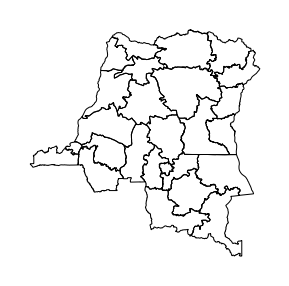

In [39]:
gpl.polyplot(zone_gd, figsize=(5,5))
plt.show()

# Mobility Visualization

## $\Delta$ Mobillity (IN) By Provinces

In [40]:
df_temp = df.groupby(by=['Date','Date_day','Destination'],as_index=0).sum()

In [41]:
df_temp[df_temp.Destination == 'Kinshasa']

Date  Date_day Destination  Volume
9    2020-02-01         5    Kinshasa   58649
29   2020-02-02         6    Kinshasa   43997
49   2020-02-03         0    Kinshasa   33236
73   2020-02-04         1    Kinshasa   35346
95   2020-02-06         3    Kinshasa   47588
...         ...       ...         ...     ...
7054 2020-12-30         2    Kinshasa   61138
7077 2020-12-31         3    Kinshasa   64878
7098 2021-01-01         4    Kinshasa   34799
7118 2021-01-02         5    Kinshasa   17973
7138 2021-01-03         6    Kinshasa   23483

[331 rows x 4 columns]

In [42]:
df_temp['Date_type'] = df_temp['Date_day'].apply(lambda x: 'WE' if (x == 5 or x == 6) else 'JO')
df_temp

Date  Date_day   Destination  Volume Date_type
0    2020-02-01         5      Bas-Uele     106        WE
1    2020-02-01         5      Equateur     570        WE
2    2020-02-01         5  Haut-Katanga   48249        WE
3    2020-02-01         5   Haut-Lomami   51834        WE
4    2020-02-01         5     Haut-Uele    1821        WE
...         ...       ...           ...     ...       ...
7145 2021-01-03         6     Nord-Kivu   99192        WE
7146 2021-01-03         6   Nord-Ubangi    2578        WE
7147 2021-01-03         6       Sankuru     668        WE
7148 2021-01-03         6      Sud-Kivu   82389        WE
7149 2021-01-03         6        Tshopo      28        WE

[7150 rows x 5 columns]

In [43]:
# df_temp[df_temp.Destination == 'Kinshasa' ].head(20

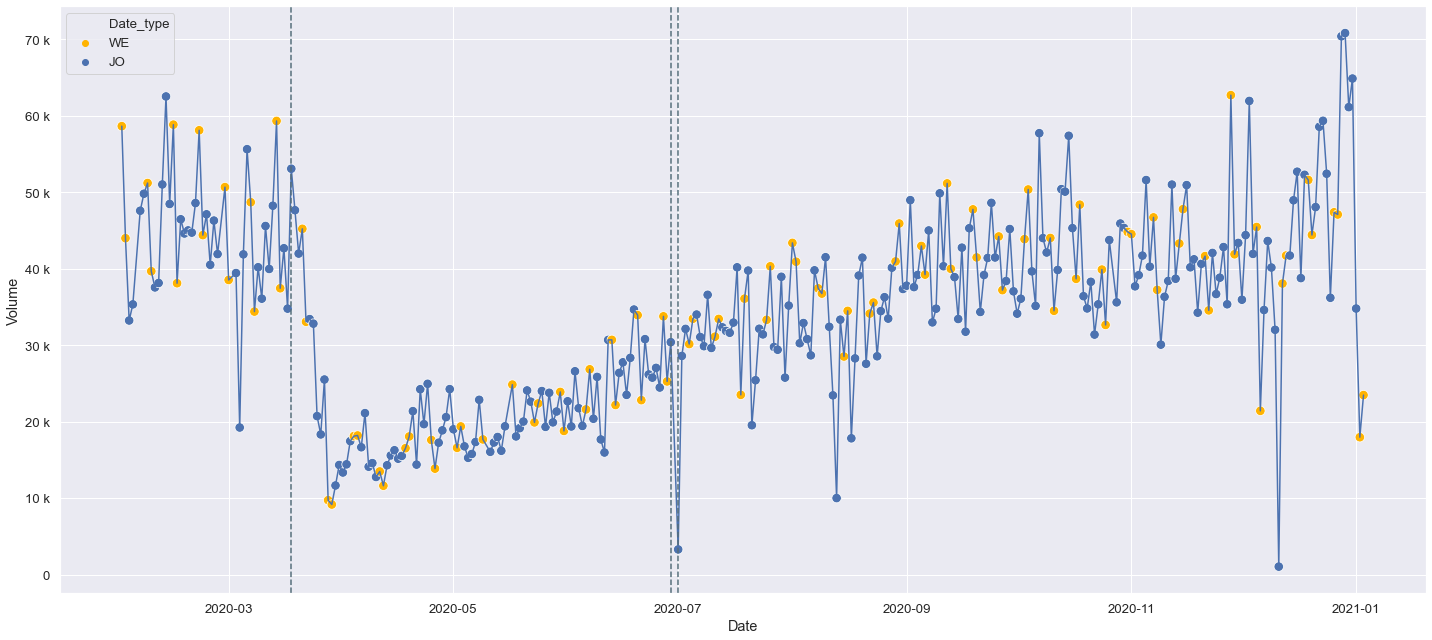

In [44]:
fig = plt.figure(figsize=(20,9))
ax = sns.lineplot(x='Date',y='Volume',data=df_temp[df_temp.Destination == 'Kinshasa' ])

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.

sns.scatterplot(x='Date',y='Volume',data=df_temp[df_temp.Destination == 'Kinshasa' ], hue = 'Date_type', ax =ax, palette = ['#ffb300','b'],s = 90)

ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = '#546e7a', ls = '--')

ax.axvline('2020-06-29',ymin = 0, ymax = 1,color = '#546e7a', ls = '--')

ax.axvline('2020-07-01',ymin = 0, ymax = 1,color = '#546e7a', ls = '--')

# ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)


plt.tight_layout()
plt.show()

In [45]:
def filter_df_from_to(start_date, end_date, df):
    mask_base = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    return df.loc[mask_base]

In [46]:
# df_p1 = filter_df_from_to('2020-02-01','2020-03-18',df)
# df_p2 = filter_df_from_to('2020-03-19','2020-06-10',df)
# df_p3 = filter_df_from_to('2020-06-11','2020-06-29',df)

In [47]:
# df_p1.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by='Destination',as_index=0).median().sort_values(by='Volume',ascending=0)

# df_p1_agg = df_p1.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by='Destination',as_index=0).median().sort_values(by='Volume',ascending=0)

# merged_df_agg = zone_gd.merge(df_p1_agg,left_on = 'PROVINCE', right_on = 'Destination' )
# gpl.choropleth(
#     merged_df_agg, hue=merged_df_agg['Volume'],
#     cmap='Reds', figsize=(12, 12),
#     legend=True
#     , legend_kwargs={'orientation': 'horizontal'}
# )
# plt.show()

In [48]:
# df_p2.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by='Destination',as_index=0).median().sort_values(by='Volume',ascending=0)

# df_p2_agg = df_p2.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by='Destination',as_index=0).median().sort_values(by='Volume',ascending=0)

# merged_df_agg = zone_gd.merge(df_p2_agg,left_on = 'PROVINCE', right_on = 'Destination' )
# gpl.choropleth(
#     merged_df_agg, hue=merged_df_agg['Volume'],
#     cmap='Reds', figsize=(12, 12),
#     legend=True
#     , legend_kwargs={'orientation': 'horizontal'}
# )
# plt.show()

In [49]:
# df_p3.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by='Destination',as_index=0).median().sort_values(by='Volume',ascending=0)

# df_p3_agg = df_p3.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by='Destination',as_index=0).median().sort_values(by='Volume',ascending=0)

# merged_df_agg = zone_gd.merge(df_p3_agg,left_on = 'PROVINCE', right_on = 'Destination' )
# gpl.choropleth(
#     merged_df_agg, hue=merged_df_agg['Volume'],
#     cmap='Reds', figsize=(12, 12),
#     legend=True
#     , legend_kwargs={'orientation': 'horizontal'}
# )
# plt.show()

In [50]:
# #Comparison between p1 and p2

# df_merged_agg = pd.merge(df_p1_agg,df_p2_agg,left_on='Destination',right_on='Destination')

# df_merged_agg['diffVolume'] = (df_merged_agg.Volume_y - df_merged_agg.Volume_x )

# df_merged_agg['deltaVolume'] = df_merged_agg['diffVolume']/df_merged_agg.Volume_x*100
# df_merged_agg = df_merged_agg.sort_values(by='Destination')
# df_merged_agg

In [51]:
# merged_df_agg = zone_gd.merge(df_merged_agg,left_on = 'PROVINCE', right_on = 'Destination' )
# gpl.choropleth(
#     merged_df_agg, hue=merged_df_agg['deltaVolume'],
#     cmap='Reds', figsize=(12, 12),
#     legend=True
#     , legend_kwargs={'orientation': 'vertical'}
# )
# plt.show()

In [52]:
# #Comparison between p1 and p3

# df_merged_agg = pd.merge(df_p1_agg,df_p3_agg,left_on='Destination',right_on='Destination')

# df_merged_agg['diffVolume'] = (df_merged_agg.Volume_y - df_merged_agg.Volume_x )

# df_merged_agg['deltaVolume'] = df_merged_agg['diffVolume']/df_merged_agg.Volume_x*100
# df_merged_agg = df_merged_agg.sort_values(by='Destination')
# df_merged_agg

In [53]:
# merged_df_agg = zone_gd.merge(df_merged_agg,left_on = 'PROVINCE', right_on = 'Destination' )
# gpl.choropleth(
#     merged_df_agg, hue=merged_df_agg['deltaVolume'],
#     cmap='Reds', figsize=(12, 12),
#     legend=True
#     , legend_kwargs={'orientation': 'horizontal'}
# )
# plt.show()

In [54]:
df[df.Destination == 'Tshuapa']

Date      Origin Destination  Volume  Date_day
80    2020-02-02    Equateur     Tshuapa     235         6
324   2020-02-06    Kinshasa     Tshuapa     157         3
574   2020-02-10    Equateur     Tshuapa      21         0
632   2020-02-10     Sankuru     Tshuapa     625         0
798   2020-02-13    Equateur     Tshuapa     113         3
835   2020-02-13    Kinshasa     Tshuapa      32         3
1159  2020-02-17      Tshopo     Tshuapa      21         0
1329  2020-02-20    Equateur     Tshuapa    1480         3
1412  2020-02-21    Equateur     Tshuapa     425         4
1489  2020-02-22    Equateur     Tshuapa     126         5
1658  2020-02-24    Kinshasa     Tshuapa      31         0
1873  2020-02-27    Kinshasa     Tshuapa      42         3
2234  2020-03-05    Kinshasa     Tshuapa      33         3
2262  2020-03-05     Sankuru     Tshuapa     751         3
2419  2020-03-08    Equateur     Tshuapa     123         6
2766  2020-03-12    Kinshasa     Tshuapa      42         3
3270  2020-03-19    Kinshasa     Tshuapa     136         3
3376  2020-03-20  Tanganyika     Tshuapa     409         4
3593  2020-03-24    Equateur     Tshuapa    1861         1
4272  2020-04-07    Equateur     Tshuapa     126         1
7127  2020-06-03      Tshopo     Tshuapa      24         2
10191 2020-07-27    Kinshasa     Tshuapa      26         0
10845 2020-08-07    Kinshasa     Tshuapa      26         4
11416 2020-08-18    Kinshasa     Tshuapa      29         1
11543 2020-08-20    Kinshasa     Tshuapa      54         3
11690 2020-08-22     Sankuru     Tshuapa      64         5
11725 2020-08-23    Kinshasa     Tshuapa      54         6
13335 2020-09-17    Kinshasa     Tshuapa      73         3
13779 2020-09-24    Kinshasa     Tshuapa      49         3
14701 2020-10-08    Kinshasa     Tshuapa      23         3
16442 2020-11-05    Kinshasa     Tshuapa      24         3
16818 2020-11-11    Kinshasa     Tshuapa      24         2
16884 2020-11-12    Kinshasa     Tshuapa      73         3
16915 2020-11-13    Equateur     Tshuapa     812         4
16952 2020-11-13    Kinshasa     Tshuapa      23         4
17087 2020-11-15    Kinshasa     Tshuapa      48         6
17149 2020-11-16    Kinshasa     Tshuapa      24         0
17349 2020-11-19    Kinshasa     Tshuapa      24         3
17410 2020-11-20    Kinshasa     Tshuapa      24         4
17540 2020-11-22    Kinshasa     Tshuapa      23         6
17604 2020-11-23    Kinshasa     Tshuapa      24         0
17769 2020-11-26    Equateur     Tshuapa      24         3
18577 2020-12-08    Kinshasa     Tshuapa      24         1
18719 2020-12-10    Kinshasa     Tshuapa      24         3
19137 2020-12-17    Kinshasa     Tshuapa      78         3
19850 2020-12-28    Kinshasa     Tshuapa      27         0
19985 2020-12-30    Kinshasa     Tshuapa      25         2

In [55]:
check_missing_dates(df[df.Destination == 'Tshuapa'],'2020-02-1','2020-08-11')

{'2020-02-01',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-11',
 '2020-02-12',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-18',
 '2020-02-19',
 '2020-02-23',
 '2020-02-25',
 '2020-02-26',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-06',
 '2020-03-07',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-08',
 '2020-04-09',
 '2020-04-10',
 '2020-04-11',
 '2020-04-12',
 '2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16',
 '2020-04-17',
 '2020-04-18',
 '2020-04-19',
 '2020-04-20',
 '2020-04-21',
 '2020-04-22',
 '2020-04-23',
 '2020-04-

In [60]:
# mobility with baseline  (the starting date of lockdown in DRC)
ref_start_date = '2020-02-01'
ref_end_date = '2020-03-18'

# mask_base = (df['Date'] >= ref_start_date) & (df['Date'] <= ref_end_date)

obs_start_date = '2020-03-19'
obs_end_date = '2021-01-04'

# mask_obs = (df['Date'] >= obs_start_date) & (df['Date'] <= obs_end_date)

df_ref = filter_df_from_to(ref_start_date,ref_end_date,df)#df.loc[mask_base]
df_obs = filter_df_from_to(obs_start_date,obs_end_date,df)#df.loc[mask_obs]


## Reference period

In [61]:
df_ref_agg = df_ref.groupby(by=['Date','Destination','Date_day'],as_index=0).sum()
# df_ref_agg[df_ref_agg.Destination == 'Kinshasa']

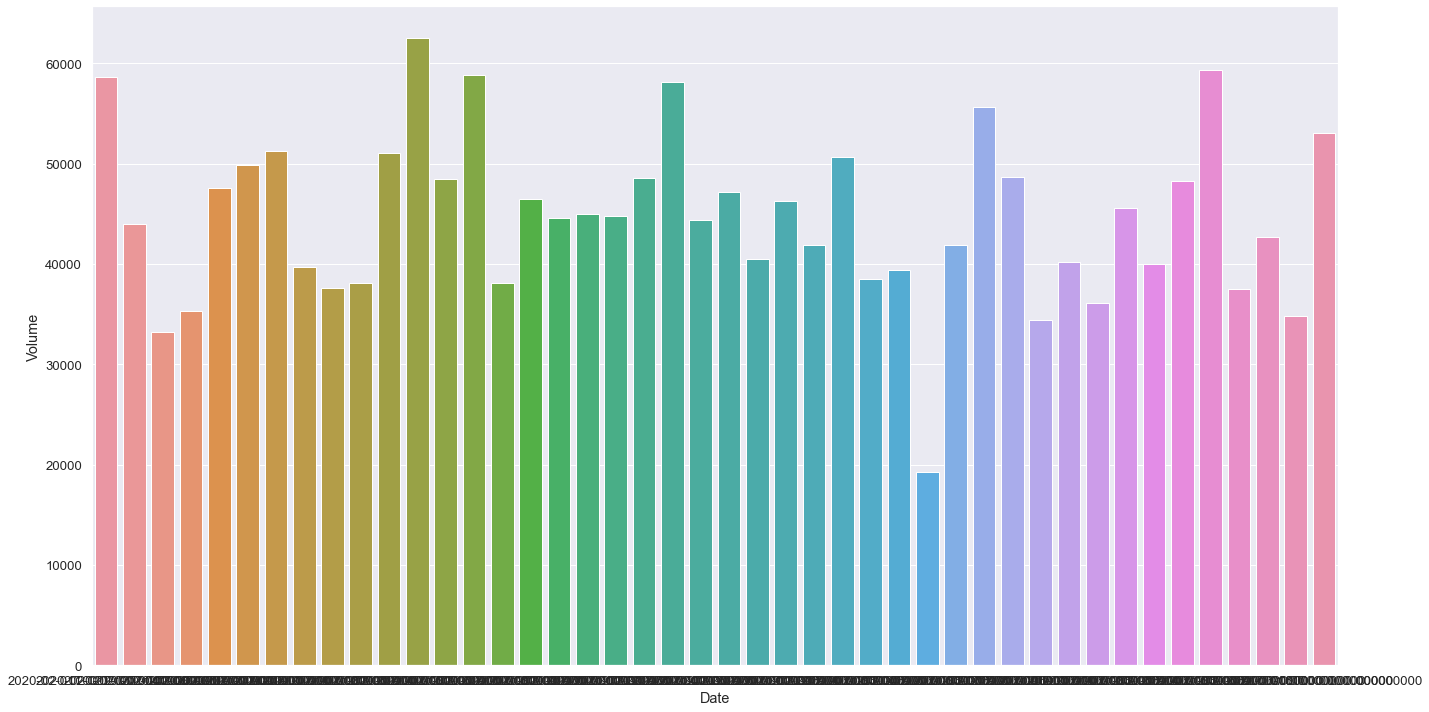

In [62]:
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x='Date',y='Volume',data=df_ref_agg[df_ref_agg.Destination == 'Kinshasa'])

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.
# ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = 'r')
# ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)
plt.tight_layout()
plt.show()

In [63]:
df_ref_agg = df_ref.groupby(by=['Date','Destination'],as_index=0).sum()
df_ref_agg = df_ref_agg.groupby(by='Destination',as_index=0).median().sort_values(by='Volume',ascending=0)
# df_ref_agg.to_clipboard()
df_ref_agg.drop('Date_day',inplace=True,axis = 1)
df_ref_agg

Destination    Volume
8   Kasai-Oriental  130781.5
13          Lomami  125649.0
18       Nord-Kivu  107298.0
21        Sud-Kivu   87766.5
3      Haut-Lomami   47340.0
9         Kinshasa   44670.5
2     Haut-Katanga   42425.5
7    Kasai-Central   42142.0
14         Lualaba   38031.5
10   Kongo-Central   27768.0
6            Kasai   24722.0
5            Ituri   16595.5
12           Kwilu   10157.0
11          Kwango    6102.0
24          Tshopo    3636.5
22      Sud-Ubangi    2709.0
19     Nord-Ubangi    2149.0
15      Mai-Ndombe    1377.5
4        Haut-Uele     830.5
23      Tanganyika     769.0
1         Equateur     511.0
17         Mongala     443.0
16         Maniema     293.0
25         Tshuapa     145.0
0         Bas-Uele     122.0
20         Sankuru      50.0

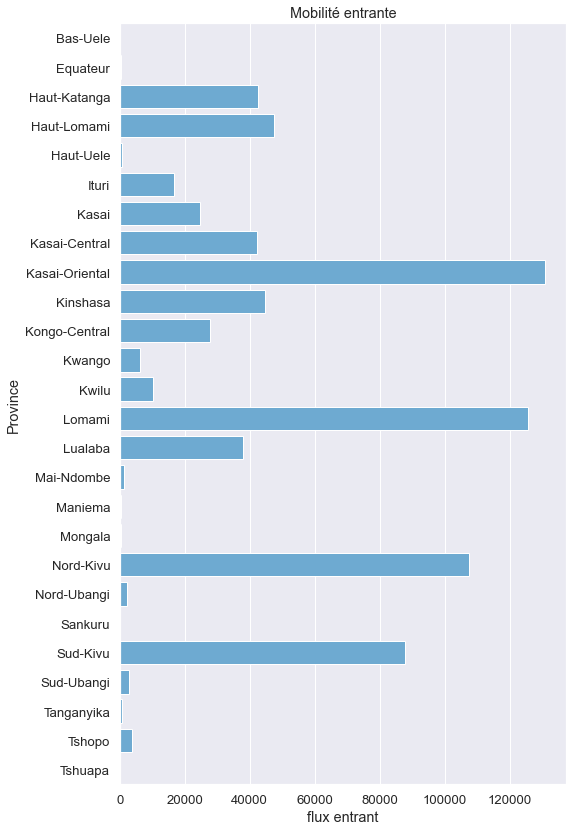

In [64]:
fig = plt.figure(figsize=(8,14))
ax = sns.barplot(y="Destination", x="Volume", palette=['#5DADE2'],data=df_ref_agg.sort_values(by = 'Destination',ascending=1), orient = 'h')
ax.set(title = 'Mobilité entrante',xlabel = "flux entrant",ylabel = 'Province')
plt.show()

In [65]:
# merged_df_agg = zone_gd.merge(df_ref_agg,left_on = 'PROVINCE', right_on = 'Destination' )
# gpl.choropleth(
#     merged_df_agg, hue=merged_df_agg['Volume'],
#     cmap='Reds', figsize=(12, 12),
#     legend=True
#     , legend_kwargs={'orientation': 'horizontal'}
# )
# plt.show()

## Observation period

In [66]:
df_obs_agg = df_obs.groupby(by=['Date','Date_day','Destination'],as_index=0).sum()
df_obs_agg[df_obs_agg.Destination == 'Kinshasa']

Date  Date_day Destination  Volume
8    2020-03-19         3    Kinshasa   47660
30   2020-03-20         4    Kinshasa   41986
54   2020-03-21         5    Kinshasa   45224
75   2020-03-22         6    Kinshasa   33068
98   2020-03-23         0    Kinshasa   33420
...         ...       ...         ...     ...
6042 2020-12-30         2    Kinshasa   61138
6065 2020-12-31         3    Kinshasa   64878
6086 2021-01-01         4    Kinshasa   34799
6106 2021-01-02         5    Kinshasa   17973
6126 2021-01-03         6    Kinshasa   23483

[287 rows x 4 columns]

In [67]:
df_obs_agg = df_obs.groupby(by=['Date','Destination'],as_index=0).sum()

df_obs_agg = df_obs_agg.groupby(by='Destination',as_index=0).median().sort_values(by='Volume',ascending=0)
# df_ref_agg.to_clipboard()
df_obs_agg.drop('Date_day',inplace=True,axis = 1)
df_obs_agg

Destination    Volume
8   Kasai-Oriental  129355.0
13          Lomami  121906.5
18       Nord-Kivu  101905.0
21        Sud-Kivu   85710.0
7    Kasai-Central   44822.0
2     Haut-Katanga   42218.0
3      Haut-Lomami   38603.0
14         Lualaba   37807.0
9         Kinshasa   33778.0
10   Kongo-Central   22716.0
5            Ituri   13826.0
6            Kasai    9034.5
12           Kwilu    7809.0
11          Kwango    4016.0
24          Tshopo    2536.0
15      Mai-Ndombe    2442.0
22      Sud-Ubangi    1351.0
19     Nord-Ubangi    1259.0
4        Haut-Uele     740.0
20         Sankuru     356.0
16         Maniema     153.0
23      Tanganyika     119.5
17         Mongala      99.0
1         Equateur      91.0
0         Bas-Uele      64.0
25         Tshuapa      26.5

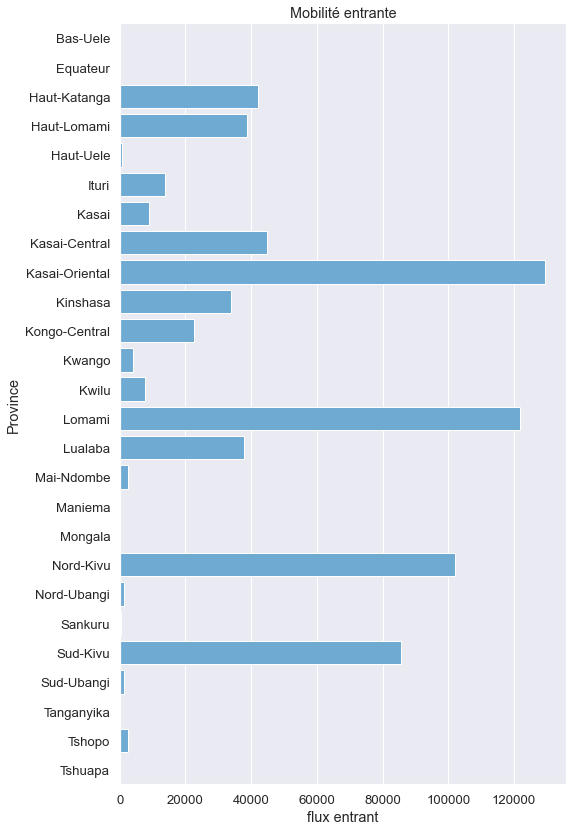

In [68]:
fig = plt.figure(figsize=(8,14))
ax = sns.barplot(y="Destination", x="Volume", palette=['#5DADE2'],data=df_obs_agg.sort_values(by = 'Destination',ascending=1), orient = 'h')
ax.set(title = 'Mobilité entrante',xlabel = "flux entrant",ylabel = 'Province')
plt.show()

In [69]:
# merged_df_agg = zone_gd.merge(df_obs_agg,left_on = 'PROVINCE', right_on = 'Destination' )
# gpl.choropleth(
#     merged_df_agg, hue=merged_df_agg['Volume'],
#     cmap='Reds', figsize=(12, 12),
#     legend=True
#     , legend_kwargs={'orientation': 'horizontal'}
# )
# plt.show()

## Comparison

In [70]:
df_merged_agg = pd.merge(df_ref_agg,df_obs_agg,left_on='Destination',right_on='Destination')

df_merged_agg['diffVolume'] = (df_merged_agg.Volume_y - df_merged_agg.Volume_x )

df_merged_agg['deltaVolume'] = df_merged_agg['diffVolume']/df_merged_agg.Volume_x*100
df_merged_agg = df_merged_agg.sort_values(by='deltaVolume')
df_merged_agg

Destination  Volume_x  Volume_y  diffVolume  deltaVolume
19      Tanganyika     769.0     119.5      -649.5   -84.460338
20        Equateur     511.0      91.0      -420.0   -82.191781
23         Tshuapa     145.0      26.5      -118.5   -81.724138
21         Mongala     443.0      99.0      -344.0   -77.652370
10           Kasai   24722.0    9034.5    -15687.5   -63.455627
15      Sud-Ubangi    2709.0    1351.0     -1358.0   -50.129199
22         Maniema     293.0     153.0      -140.0   -47.781570
24        Bas-Uele     122.0      64.0       -58.0   -47.540984
16     Nord-Ubangi    2149.0    1259.0      -890.0   -41.414611
13          Kwango    6102.0    4016.0     -2086.0   -34.185513
14          Tshopo    3636.5    2536.0     -1100.5   -30.262615
5         Kinshasa   44670.5   33778.0    -10892.5   -24.384101
12           Kwilu   10157.0    7809.0     -2348.0   -23.117062
4      Haut-Lomami   47340.0   38603.0     -8737.0   -18.455851
9    Kongo-Central   27768.0   22716.0     -5052.0   -18.193604
11           Ituri   16595.5   13826.0     -2769.5   -16.688259
18       Haut-Uele     830.5     740.0       -90.5   -10.897050
2        Nord-Kivu  107298.0  101905.0     -5393.0    -5.026189
1           Lomami  125649.0  121906.5     -3742.5    -2.978535
3         Sud-Kivu   87766.5   85710.0     -2056.5    -2.343149
0   Kasai-Oriental  130781.5  129355.0     -1426.5    -1.090751
8          Lualaba   38031.5   37807.0      -224.5    -0.590300
6     Haut-Katanga   42425.5   42218.0      -207.5    -0.489093
7    Kasai-Central   42142.0   44822.0      2680.0     6.359451
17      Mai-Ndombe    1377.5    2442.0      1064.5    77.277677
25         Sankuru      50.0     356.0       306.0   612.000000

In [71]:
df[df.Destination == 'Tshuapa'].groupby(['Date','Date_day', 'Destination'], as_index=False).sum()

Date  Date_day Destination  Volume
0  2020-02-02         6     Tshuapa     235
1  2020-02-06         3     Tshuapa     157
2  2020-02-10         0     Tshuapa     646
3  2020-02-13         3     Tshuapa     145
4  2020-02-17         0     Tshuapa      21
5  2020-02-20         3     Tshuapa    1480
6  2020-02-21         4     Tshuapa     425
7  2020-02-22         5     Tshuapa     126
8  2020-02-24         0     Tshuapa      31
9  2020-02-27         3     Tshuapa      42
10 2020-03-05         3     Tshuapa     784
11 2020-03-08         6     Tshuapa     123
12 2020-03-12         3     Tshuapa      42
13 2020-03-19         3     Tshuapa     136
14 2020-03-20         4     Tshuapa     409
15 2020-03-24         1     Tshuapa    1861
16 2020-04-07         1     Tshuapa     126
17 2020-06-03         2     Tshuapa      24
18 2020-07-27         0     Tshuapa      26
19 2020-08-07         4     Tshuapa      26
20 2020-08-18         1     Tshuapa      29
21 2020-08-20         3     Tshuapa      54
22 2020-08-22         5     Tshuapa      64
23 2020-08-23         6     Tshuapa      54
24 2020-09-17         3     Tshuapa      73
25 2020-09-24         3     Tshuapa      49
26 2020-10-08         3     Tshuapa      23
27 2020-11-05         3     Tshuapa      24
28 2020-11-11         2     Tshuapa      24
29 2020-11-12         3     Tshuapa      73
30 2020-11-13         4     Tshuapa     835
31 2020-11-15         6     Tshuapa      48
32 2020-11-16         0     Tshuapa      24
33 2020-11-19         3     Tshuapa      24
34 2020-11-20         4     Tshuapa      24
35 2020-11-22         6     Tshuapa      23
36 2020-11-23         0     Tshuapa      24
37 2020-11-26         3     Tshuapa      24
38 2020-12-08         1     Tshuapa      24
39 2020-12-10         3     Tshuapa      24
40 2020-12-17         3     Tshuapa      78
41 2020-12-28         0     Tshuapa      27
42 2020-12-30         2     Tshuapa      25

In [72]:
# dict_mob = {}
# for dest in list((df.groupby(by = 'Destination').groups.keys())):
#     baseline_value = df_ref['Volume'].loc[df_ref['Destination'] == dest ].sum() 
#      #avoid division by zero
#     if(baseline_value == 0):
#         continue
#     current_value = df_obs['Volume'].loc[df_obs['Destination'] == dest ].sum() 
#     dict_mob[dest] = (current_value - baseline_value)*100/baseline_value
# dict_mob
# df_mobility = pd.DataFrame(dict(provinces = list(dict_mob.keys()),Volume = list(dict_mob.values())))
# df_mobility

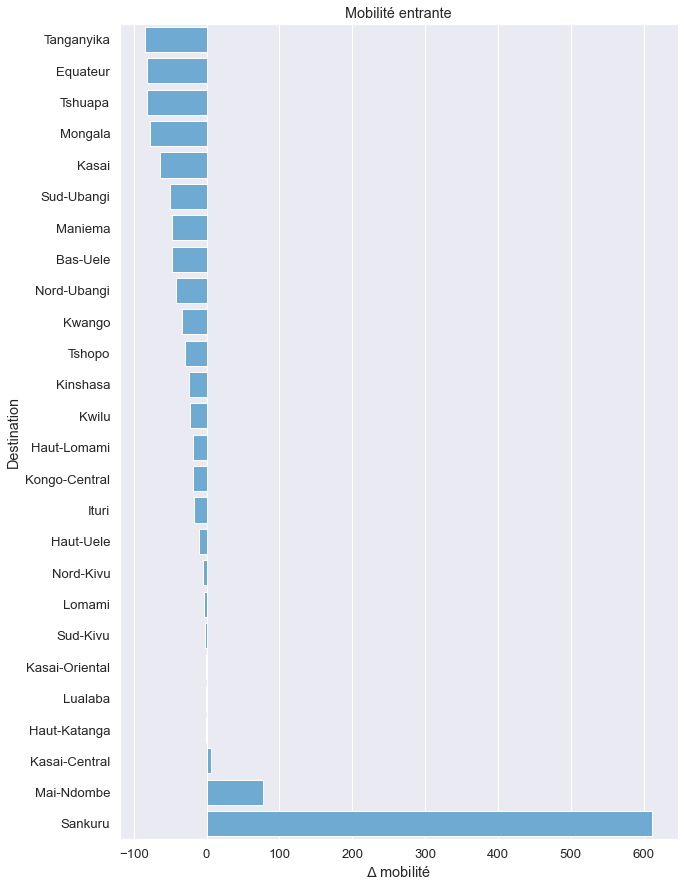

In [73]:
fig = plt.figure(figsize=(10,15))
ax = sns.barplot(y="Destination", x="deltaVolume",palette=['#5DADE2'], data=df_merged_agg, orient = 'h')
ax.set(title = 'Mobilité entrante',xlabel = '$\Delta$ mobilité')
plt.show()

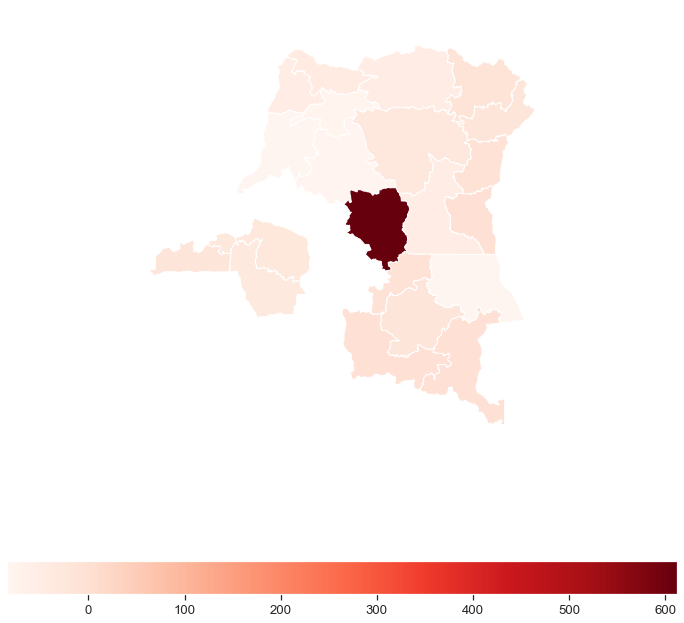

In [74]:
merged_agg = zone_gd.merge(df_merged_agg,left_on = 'PROVINCE', right_on = 'Destination' )
gpl.choropleth(
    merged_agg, hue=merged_agg['deltaVolume'],
    cmap='Reds', figsize=(12, 12),
    legend=True
    , legend_kwargs={'orientation': 'horizontal'}
)
plt.show()

### Mobillity (IN) trends By Provinces

In [271]:
df_ref_agg_date_day = df_ref.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by=['Destination','Date_day'],as_index=0).median()
df_ref_agg_date_day[df_ref_agg_date_day.Destination == 'Kinshasa']

Destination  Date_day   Volume
63    Kinshasa         0  41444.5
64    Kinshasa         1  38143.0
65    Kinshasa         2  45949.5
66    Kinshasa         3  43324.5
67    Kinshasa         4  48593.0
68    Kinshasa         5  58111.0
69    Kinshasa         6  38537.0

In [272]:
df_obs_agg_date_dest_dd = df_obs.groupby(by=['Date','Destination','Date_day'],as_index=0).sum()
df_obs_agg_date_dest_dd[df_obs_agg_date_dest_dd.Destination == 'Kinshasa']

Date Destination  Date_day  Volume
8    2020-03-19    Kinshasa         3   47660
30   2020-03-20    Kinshasa         4   41986
54   2020-03-21    Kinshasa         5   45224
75   2020-03-22    Kinshasa         6   33068
98   2020-03-23    Kinshasa         0   33420
...         ...         ...       ...     ...
2985 2020-08-07    Kinshasa         4   39797
3004 2020-08-08    Kinshasa         5   37437
3025 2020-08-09    Kinshasa         6   36756
3046 2020-08-10    Kinshasa         0   41511
3067 2020-08-11    Kinshasa         1   32411

[143 rows x 4 columns]

In [273]:
df_trend = pd.merge(df_obs_agg_date_dest_dd,df_ref_agg_date_day,left_on=['Destination','Date_day'],right_on=['Destination','Date_day']).sort_values(by='Date')

In [275]:
df_trend['deltaV'] = (df_trend['Volume_x'] - df_trend['Volume_y'])/df_trend['Volume_y']*100
# df_trend = df_trend[df_trend.Destination == 'Kinshasa']
df_trend

Date  Destination  Date_day  Volume_x  Volume_y      deltaV
0    2020-03-19     Bas-Uele         3        62     104.0  -40.384615
392  2020-03-19       Tshopo         3     11905    7823.0   52.179471
376  2020-03-19   Tanganyika         3      2165     680.0  218.382353
355  2020-03-19     Sud-Kivu         3     80922   86111.5   -6.026489
335  2020-03-19  Nord-Ubangi         3      4819    2092.5  130.298686
...         ...          ...       ...       ...       ...         ...
3021 2020-08-11      Sankuru         1       606     239.0  153.556485
2173 2020-08-11        Ituri         1     18001   22998.0  -21.727976
2138 2020-08-11  Haut-Lomami         1     32605   48481.0  -32.746849
2098 2020-08-11     Bas-Uele         1        43     825.5  -94.791036
2497 2020-08-11       Tshopo         1      4499    1228.0  266.368078

[3056 rows x 6 columns]

In [276]:
set(df_trend.Destination)

{'Bas-Uele',
 'Equateur',
 'Haut-Katanga',
 'Haut-Lomami',
 'Haut-Uele',
 'Ituri',
 'Kasai',
 'Kasai-Central',
 'Kasai-Oriental',
 'Kinshasa',
 'Kongo-Central',
 'Kwango',
 'Kwilu',
 'Lomami',
 'Lualaba',
 'Mai-Ndombe',
 'Maniema',
 'Mongala',
 'Nord-Kivu',
 'Nord-Ubangi',
 'Sankuru',
 'Sud-Kivu',
 'Sud-Ubangi',
 'Tanganyika',
 'Tshopo',
 'Tshuapa'}

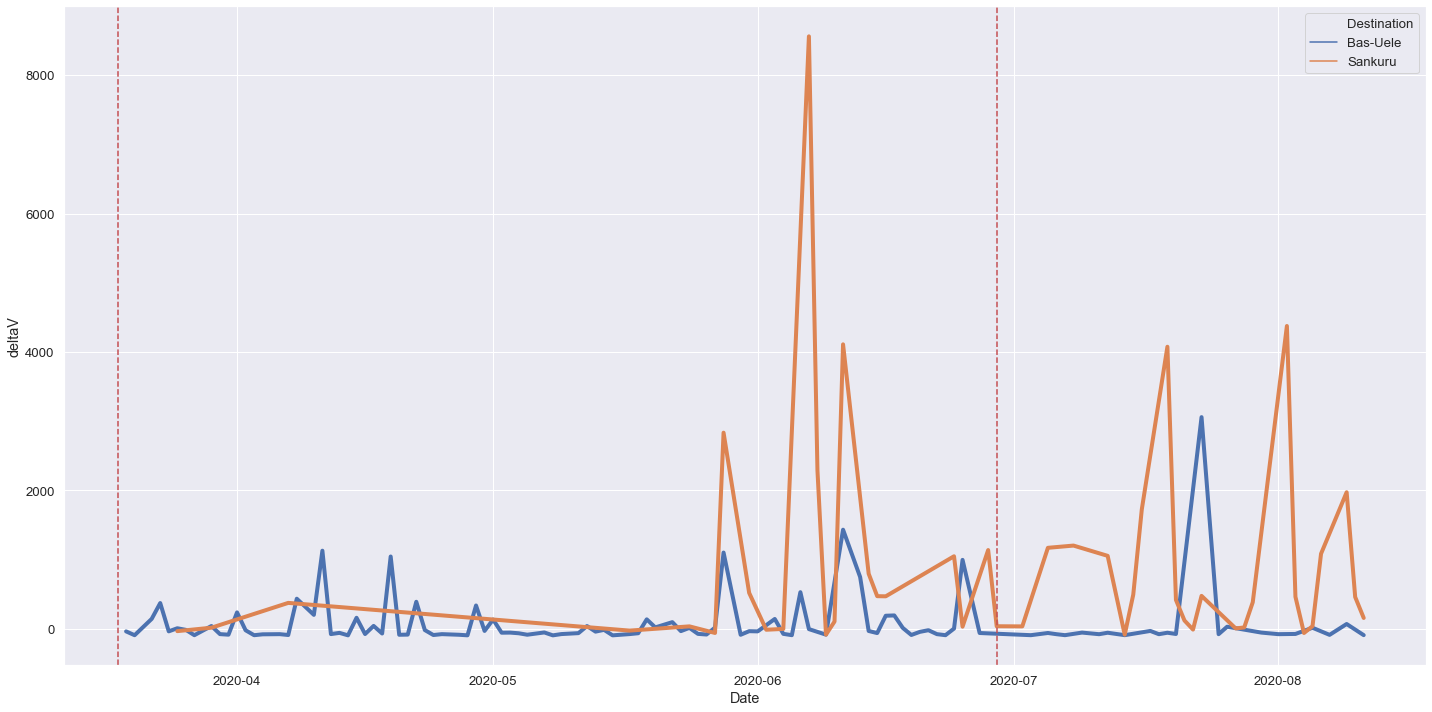

In [291]:
provinces_excluded = [
    #'Bas-Uele',
 'Equateur',
  #'Haut-Katanga',
  #'Haut-Lomami',
 'Haut-Uele',
 'Ituri',
 'Kasai',
 #'Kasai-Central',
 'Kasai-Oriental',
  #'Kinshasa',
  #'Kongo-Central',
 'Kwango',
 'Kwilu',
 'Lomami',
 'Lualaba',
 'Mai-Ndombe',
 'Maniema',
 'Mongala',
  #'Nord-Kivu',
 'Nord-Ubangi',
 'Sankuru',
 'Sud-Kivu',
 'Sud-Ubangi',
 'Tanganyika',
 'Tshopo',
 'Tshuapa']

province_to_plot = ['Sankuru','Bas-Uele',]#['Tshopo','Tanganyika','Maniema']#,['Tshuapa','Mongala','Equateur',]
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x='Date',y='deltaV',data=df_trend[(df_trend.Destination.isin(province_to_plot))], hue = 'Destination',linewidth = 4)

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.

# sns.scatterplot(x='Date',y='Volume',data=df_temp[df_temp.Destination == 'Kinshasa' ], hue = 'Date_type', ax =ax, palette = ['#ffb300','b'])

ax.axvline('2020-06-29',ymin = 0, ymax = 1,color = 'r', ls = '--')

ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = 'r', ls = '--')

# ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
# ax.yaxis.set_major_formatter(ticker.EngFormatter())
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)


plt.tight_layout()
plt.show()

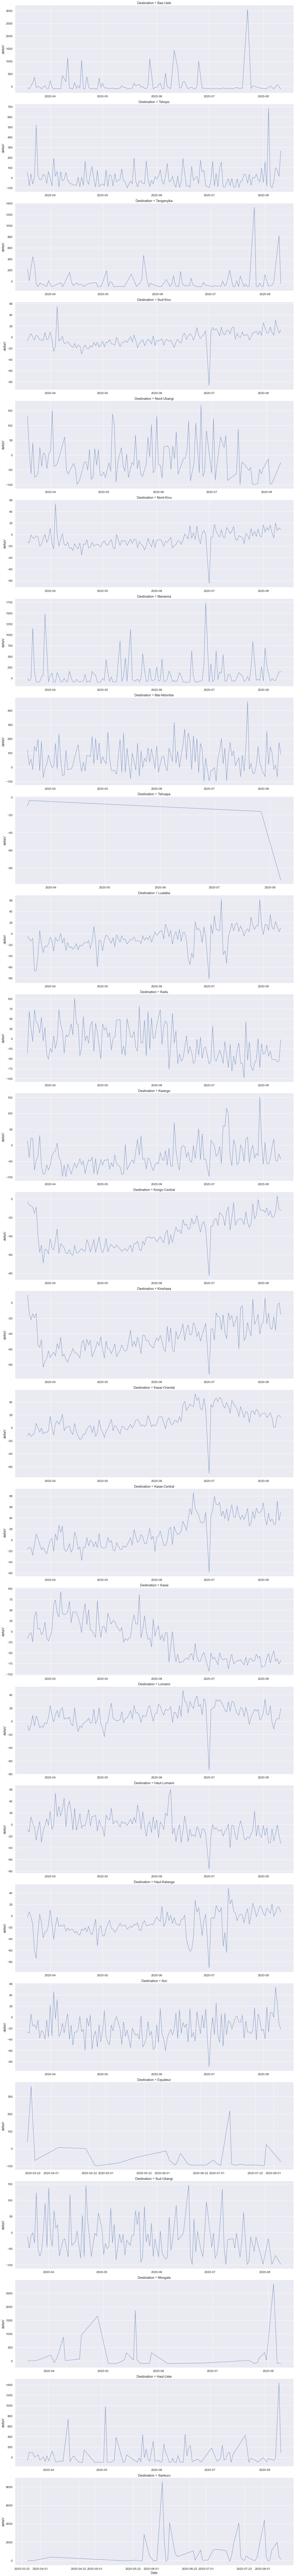

In [281]:
g = sns.FacetGrid(df_trend, row="Destination",aspect=3,height=6,sharey=False,sharex=False)
# g.map(sns.lineplot, x='Date',y='deltaV', alpha=.7)
g.map(plt.plot, "Date", "deltaV", alpha=.7)
# sns.lineplot(x='Date',y='deltaV',data=df_trend)
g.add_legend();

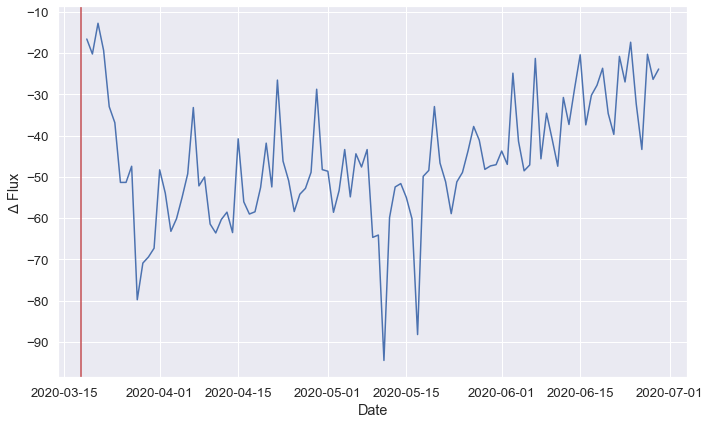

In [169]:
fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(x='Date',y='deltaV',data=df_trend[df_trend.Destination == 'Kinshasa'])

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.
ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = 'r')
# ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')

ax.set(ylabel = '$\Delta$ Flux')
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)
plt.tight_layout()
plt.show()

In [170]:
df_trend[df_trend.Destination == 'Kinshasa']

Date Destination  Date_day  Volume_x  Volume_y     deltaV
117  2020-03-19    Kinshasa         3     21969   26335.0 -16.578698
419  2020-03-20    Kinshasa         4     24036   30121.5 -20.203177
738  2020-03-21    Kinshasa         5     28313   32452.0 -12.754222
1052 2020-03-22    Kinshasa         6     21785   27009.0 -19.341701
1368 2020-03-23    Kinshasa         0     17117   25536.0 -32.969142
...         ...         ...       ...       ...       ...        ...
131  2020-06-25    Kinshasa         3     17819   26335.0 -32.337194
433  2020-06-26    Kinshasa         4     17066   30121.5 -43.342795
752  2020-06-27    Kinshasa         5     25873   32452.0 -20.273019
1066 2020-06-28    Kinshasa         6     19892   27009.0 -26.350476
1382 2020-06-29    Kinshasa         0     19446   25536.0 -23.848684

[103 rows x 6 columns]

## $\Delta$ Mobillity (OUT) By Provinces

In [136]:
df_temp = df.groupby(by=['Date','Origin'],as_index=0).sum()

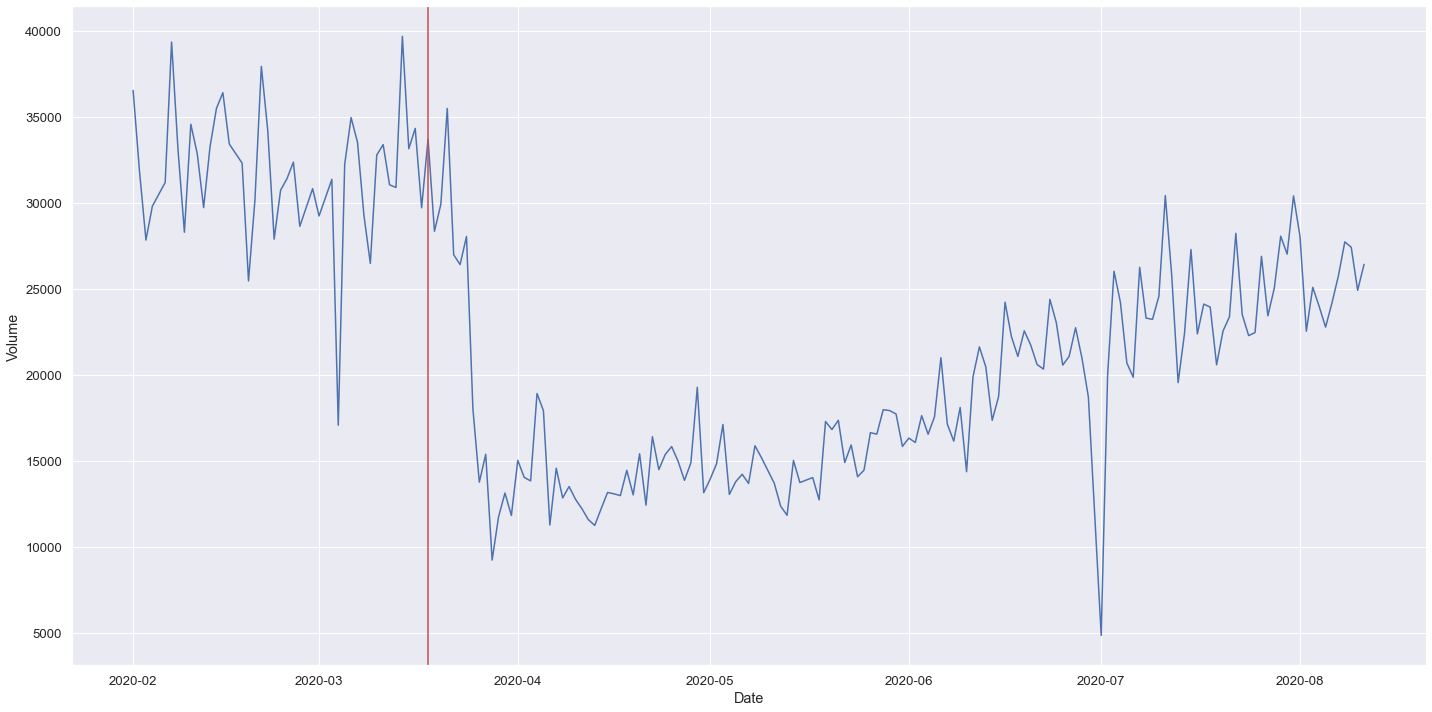

In [137]:
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x='Date',y='Volume',data=df_temp[df_temp.Origin == 'Kinshasa' ])

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.
ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = 'r')

# ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)
plt.tight_layout()
plt.show()

In [138]:
df_tshuapa = df[df.Origin == 'Tshuapa']
df_tshuapa = df_tshuapa.groupby(by=['Date','Origin'],as_index=0).sum()
df_tshuapa

Date   Origin  Volume  Date_day
0  2020-02-06  Tshuapa    1517         3
1  2020-02-12  Tshuapa    1443         2
2  2020-02-13  Tshuapa   10122         3
3  2020-02-17  Tshuapa    1522         0
4  2020-02-20  Tshuapa    5921         3
5  2020-02-21  Tshuapa     425         4
6  2020-02-27  Tshuapa    6194         6
7  2020-03-01  Tshuapa    1649         6
8  2020-03-03  Tshuapa    5055         1
9  2020-03-05  Tshuapa    4316         3
10 2020-03-09  Tshuapa    1975         0
11 2020-03-12  Tshuapa    6341         3
12 2020-03-19  Tshuapa    8512         3
13 2020-04-04  Tshuapa    8640         5
14 2020-04-22  Tshuapa    5095         2
15 2020-04-30  Tshuapa    4801         3
16 2020-07-17  Tshuapa    3521         4
17 2020-08-01  Tshuapa    4953         5

In [141]:
# mobility with baseline  (the starting date of lockdown in DRC)
ref_start_date = '2020-02-18'
ref_end_date = '2020-03-18'

# mask_base = (df['Date'] >= ref_start_date) & (df['Date'] <= ref_end_date)

obs_start_date = '2020-03-19'
obs_end_date = '2020-12-29'

# mask_obs = (df['Date'] >= obs_start_date) & (df['Date'] <= obs_end_date)

df_ref_out = filter_df_from_to(ref_start_date, ref_end_date,df)#df.loc[mask_base]
df_obs_out = filter_df_from_to(obs_start_date, obs_end_date,df)#df.loc[mask_obs]


## Reference period

In [142]:
df_ref_agg_out = df_ref_out.groupby(by=['Date','Origin'],as_index=0).sum()
df_ref_agg_out = df_ref_agg_out.groupby(by='Origin',as_index=0).median().sort_values(by='Volume',ascending=0)
# df_ref_agg.to_clipboard();
df_ref_agg_out.drop('Date_day',inplace=True,axis = 1)
df_ref_agg_out

Origin    Volume
13          Lomami  117104.5
8   Kasai-Oriental  117089.0
18       Nord-Kivu  102517.5
21        Sud-Kivu   80959.5
3      Haut-Lomami   50792.5
7    Kasai-Central   48177.0
14         Lualaba   39898.5
2     Haut-Katanga   36799.5
9         Kinshasa   31382.0
6            Kasai   27802.5
5            Ituri   24633.0
10   Kongo-Central   23828.0
12           Kwilu   16978.0
11          Kwango    7347.0
25         Tshuapa    4685.5
22      Sud-Ubangi    3098.0
19     Nord-Ubangi    2762.5
4        Haut-Uele    2005.0
23      Tanganyika    1929.0
16         Maniema    1676.0
0         Bas-Uele    1521.5
15      Mai-Ndombe    1411.5
24          Tshopo    1364.0
1         Equateur    1050.5
17         Mongala     891.0
20         Sankuru     724.5

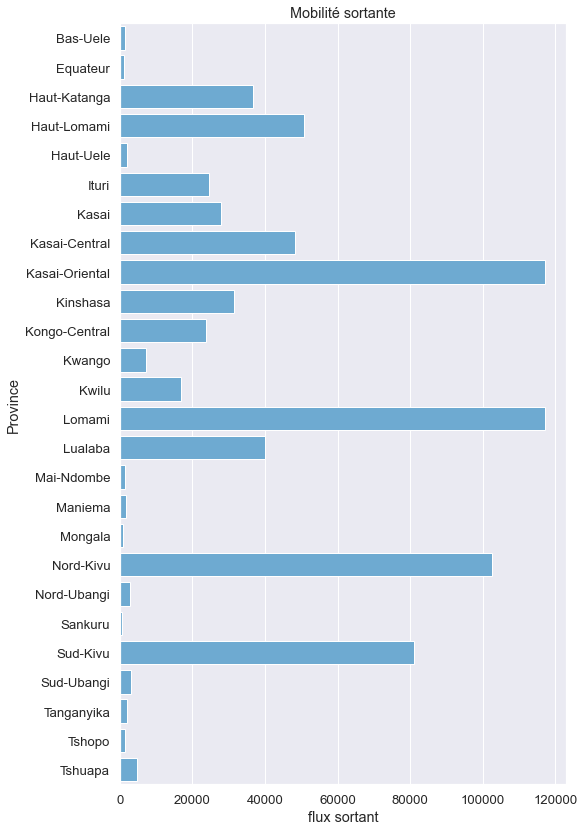

In [143]:
fig = plt.figure(figsize=(8,14))
ax = sns.barplot(y="Origin", x="Volume", palette=['#5DADE2'],data=df_ref_agg_out.sort_values(by = 'Origin',ascending=1), orient = 'h')
ax.set(title = 'Mobilité sortante',xlabel = "flux sortant",ylabel = 'Province')
plt.show()

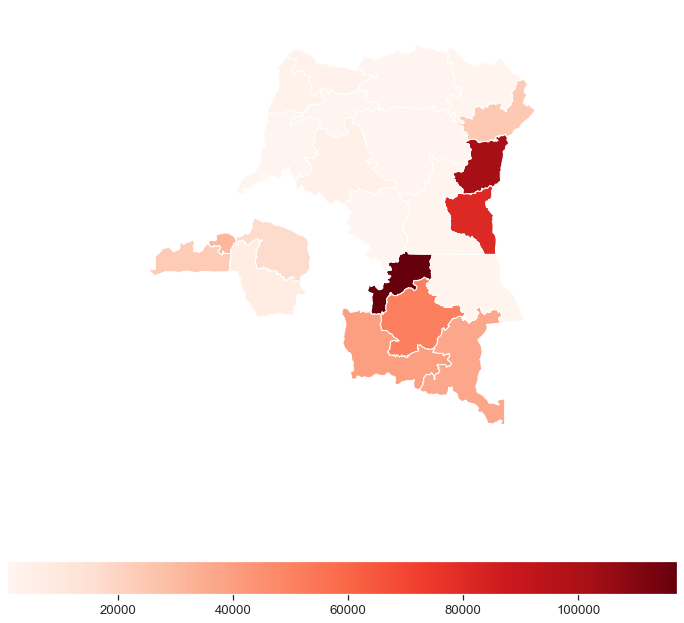

In [144]:
merged_df_agg_out = zone_gd.merge(df_ref_agg_out,left_on = 'PROVINCE', right_on = 'Origin' )
gpl.choropleth(
    merged_df_agg_out, hue=merged_df_agg_out['Volume'],
    cmap='Reds', figsize=(12, 12),
    legend=True
    , legend_kwargs={'orientation': 'horizontal'}
)
plt.show()

## Observation period

In [145]:
df_obs_agg_out = df_obs_out.groupby(by=['Date','Origin'],as_index=0).sum()
df_obs_agg_out = df_obs_agg_out.groupby(by='Origin',as_index=0).median().sort_values(by='Volume',ascending=0)
# df_ref_agg.to_clipboard()
df_obs_agg_out.drop('Date_day',inplace=True,axis = 1)
df_obs_agg_out

Origin    Volume
13          Lomami  132060.0
8   Kasai-Oriental  130813.0
18       Nord-Kivu   94992.0
21        Sud-Kivu   79540.0
3      Haut-Lomami   52550.0
7    Kasai-Central   50936.0
14         Lualaba   36577.0
2     Haut-Katanga   31904.0
6            Kasai   22867.0
5            Ituri   19449.0
9         Kinshasa   17919.0
10   Kongo-Central   16086.0
12           Kwilu   11537.0
11          Kwango    7072.5
25         Tshuapa    5024.0
19     Nord-Ubangi    2063.0
4        Haut-Uele    2014.0
22      Sud-Ubangi    1712.5
0         Bas-Uele    1538.5
16         Maniema    1424.0
15      Mai-Ndombe    1339.0
20         Sankuru    1195.0
23      Tanganyika     888.0
17         Mongala     735.5
1         Equateur     393.0
24          Tshopo     334.5

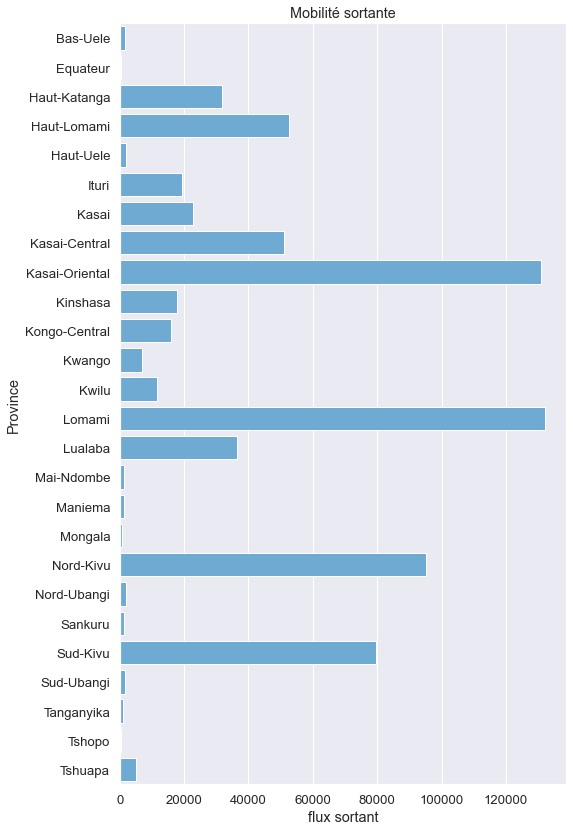

In [146]:
fig = plt.figure(figsize=(8,14))
ax = sns.barplot(y="Origin", x="Volume", palette=['#5DADE2'],data=df_obs_agg_out.sort_values(by = 'Origin',ascending=1), orient = 'h')
ax.set(title = 'Mobilité sortante',xlabel = "flux sortant",ylabel = 'Province')
plt.show()

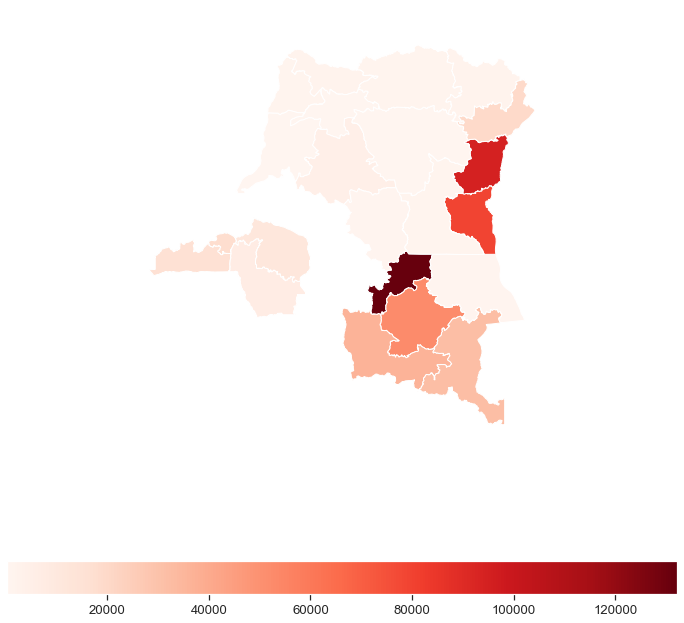

In [147]:
merged_df_agg_out = zone_gd.merge(df_obs_agg_out,left_on = 'PROVINCE', right_on = 'Origin' )
gpl.choropleth(
    merged_df_agg_out, hue=merged_df_agg_out['Volume'],
    cmap='Reds', figsize=(12, 12),
    legend=True
    , legend_kwargs={'orientation': 'horizontal'}
)
plt.show()

## Comparison

In [148]:
df_merged_agg_out = pd.merge(df_ref_agg_out,df_obs_agg_out,left_on='Origin',right_on='Origin')

df_merged_agg_out['diffVolume'] = (df_merged_agg_out.Volume_y - df_merged_agg_out.Volume_x )

df_merged_agg_out['deltaVolume'] = df_merged_agg_out['diffVolume']/df_merged_agg_out.Volume_x*100
df_merged_agg_out = df_merged_agg_out.sort_values(by='deltaVolume')
df_merged_agg_out.sort_values('deltaVolume')

Origin  Volume_x  Volume_y  diffVolume  deltaVolume
22          Tshopo    1364.0     334.5     -1029.5   -75.476540
23        Equateur    1050.5     393.0      -657.5   -62.589243
18      Tanganyika    1929.0     888.0     -1041.0   -53.965785
15      Sud-Ubangi    3098.0    1712.5     -1385.5   -44.722402
8         Kinshasa   31382.0   17919.0    -13463.0   -42.900389
11   Kongo-Central   23828.0   16086.0     -7742.0   -32.491187
12           Kwilu   16978.0   11537.0     -5441.0   -32.047355
16     Nord-Ubangi    2762.5    2063.0      -699.5   -25.321267
10           Ituri   24633.0   19449.0     -5184.0   -21.044940
9            Kasai   27802.5   22867.0     -4935.5   -17.752001
24         Mongala     891.0     735.5      -155.5   -17.452301
19         Maniema    1676.0    1424.0      -252.0   -15.035800
7     Haut-Katanga   36799.5   31904.0     -4895.5   -13.303170
6          Lualaba   39898.5   36577.0     -3321.5    -8.324874
2        Nord-Kivu  102517.5   94992.0     -7525.5    -7.340698
21      Mai-Ndombe    1411.5    1339.0       -72.5    -5.136380
13          Kwango    7347.0    7072.5      -274.5    -3.736219
3         Sud-Kivu   80959.5   79540.0     -1419.5    -1.753346
17       Haut-Uele    2005.0    2014.0         9.0     0.448878
20        Bas-Uele    1521.5    1538.5        17.0     1.117318
4      Haut-Lomami   50792.5   52550.0      1757.5     3.460157
5    Kasai-Central   48177.0   50936.0      2759.0     5.726799
14         Tshuapa    4685.5    5024.0       338.5     7.224416
1   Kasai-Oriental  117089.0  130813.0     13724.0    11.720999
0           Lomami  117104.5  132060.0     14955.5    12.771072
25         Sankuru     724.5    1195.0       470.5    64.941339

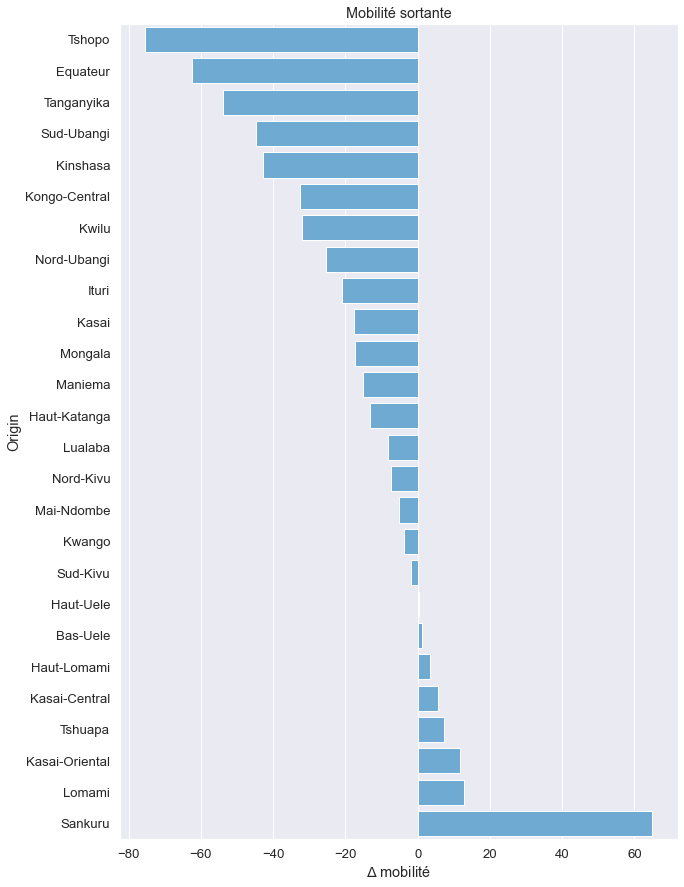

In [149]:
fig = plt.figure(figsize=(10,15))
ax = sns.barplot(y="Origin", x="deltaVolume",palette=['#5DADE2'], data=df_merged_agg_out.sort_values(by='deltaVolume'), orient = 'h')
ax.set(title = 'Mobilité sortante',xlabel = '$\Delta$ mobilité')
plt.show()

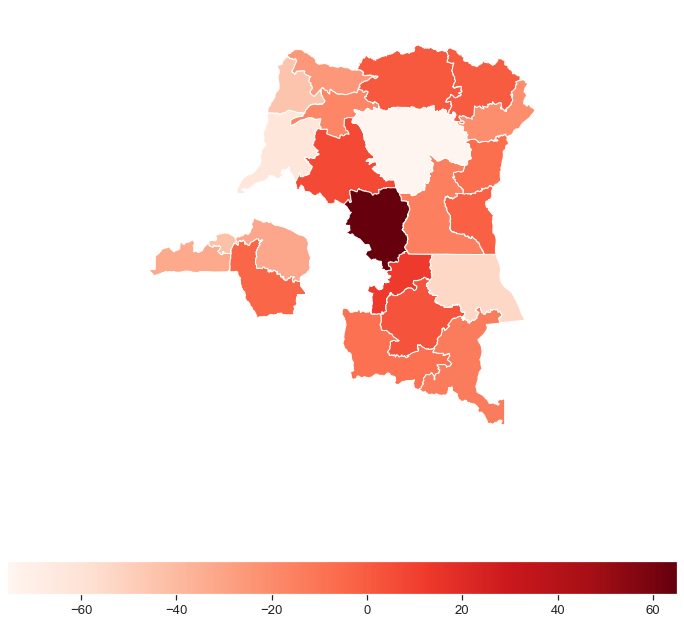

In [150]:
merged_agg_out = zone_gd.merge(df_merged_agg_out,left_on = 'PROVINCE', right_on = 'Origin' )
gpl.choropleth(
    merged_agg_out, hue=merged_agg_out['deltaVolume'],
    cmap='Reds', figsize=(12, 12),
    legend=True
    , legend_kwargs={'orientation': 'horizontal'}
)
plt.show()

### Mobillity (OUT) trends By Provinces

In [151]:
df_ref_agg_date_day = df_ref.groupby(by=['Date','Origin','Date_day'],as_index=0).sum().groupby(by=['Origin','Date_day'],as_index=0).median()
df_ref_agg_date_day[df_ref_agg_date_day.Origin == 'Kinshasa']

Origin  Date_day   Volume
63  Kinshasa         0  31794.5
64  Kinshasa         1  31404.0
65  Kinshasa         2  31037.5
66  Kinshasa         3  31111.0
67  Kinshasa         4  35491.0
68  Kinshasa         5  34203.0
69  Kinshasa         6  29274.0

In [152]:
df_obs_agg_date_dest_dd = df_obs.groupby(by=['Date','Origin','Date_day'],as_index=0).sum()
df_obs_agg_date_dest_dd[df_obs_agg_date_dest_dd.Origin == 'Kinshasa']

Date    Origin  Date_day  Volume
9    2020-03-19  Kinshasa         3   28340
32   2020-03-20  Kinshasa         4   29910
56   2020-03-21  Kinshasa         5   35482
79   2020-03-22  Kinshasa         6   26978
103  2020-03-23  Kinshasa         0   26405
...         ...       ...       ...     ...
2986 2020-08-07  Kinshasa         4   25754
3006 2020-08-08  Kinshasa         5   27726
3028 2020-08-09  Kinshasa         6   27414
3050 2020-08-10  Kinshasa         0   24910
3074 2020-08-11  Kinshasa         1   26419

[143 rows x 4 columns]

In [153]:
df_trend = pd.merge(df_obs_agg_date_dest_dd,df_ref_agg_date_day,left_on=['Origin','Date_day'],right_on=['Origin','Date_day']).sort_values(by='Date')
df_trend['deltaV'] = (df_trend['Volume_x'] - df_trend['Volume_y'])/df_trend['Volume_y']*100
# df_trend = df_trend[df_trend.Destination == 'Kinshasa']
df_trend

Date         Origin  Date_day  Volume_x  Volume_y     deltaV
0    2020-03-19       Bas-Uele         3      2498    2860.5 -12.672610
95   2020-03-19          Kasai         3     19533   29523.5 -33.839145
41   2020-03-19    Haut-Lomami         3     52550   52911.0  -0.682278
221  2020-03-19          Kwilu         3     15277   13957.0   9.457620
116  2020-03-19  Kasai-Central         3     43119   48082.5 -10.322883
...         ...            ...       ...       ...       ...        ...
2378 2020-08-11         Kwango         1     13562    9167.0  47.943711
2527 2020-08-11       Sud-Kivu         1     96049   87567.0   9.686297
2358 2020-08-11  Kongo-Central         1     21844   21941.0  -0.442095
2181 2020-08-11       Equateur         1       589     517.0  13.926499
2418 2020-08-11         Lomami         1    119225  115745.0   3.006609

[3084 rows x 6 columns]

In [154]:
df_trend['Date_type'] = df_trend['Date_day'].apply(lambda x: 'WE' if (x == 5 or x == 6) else 'JO')

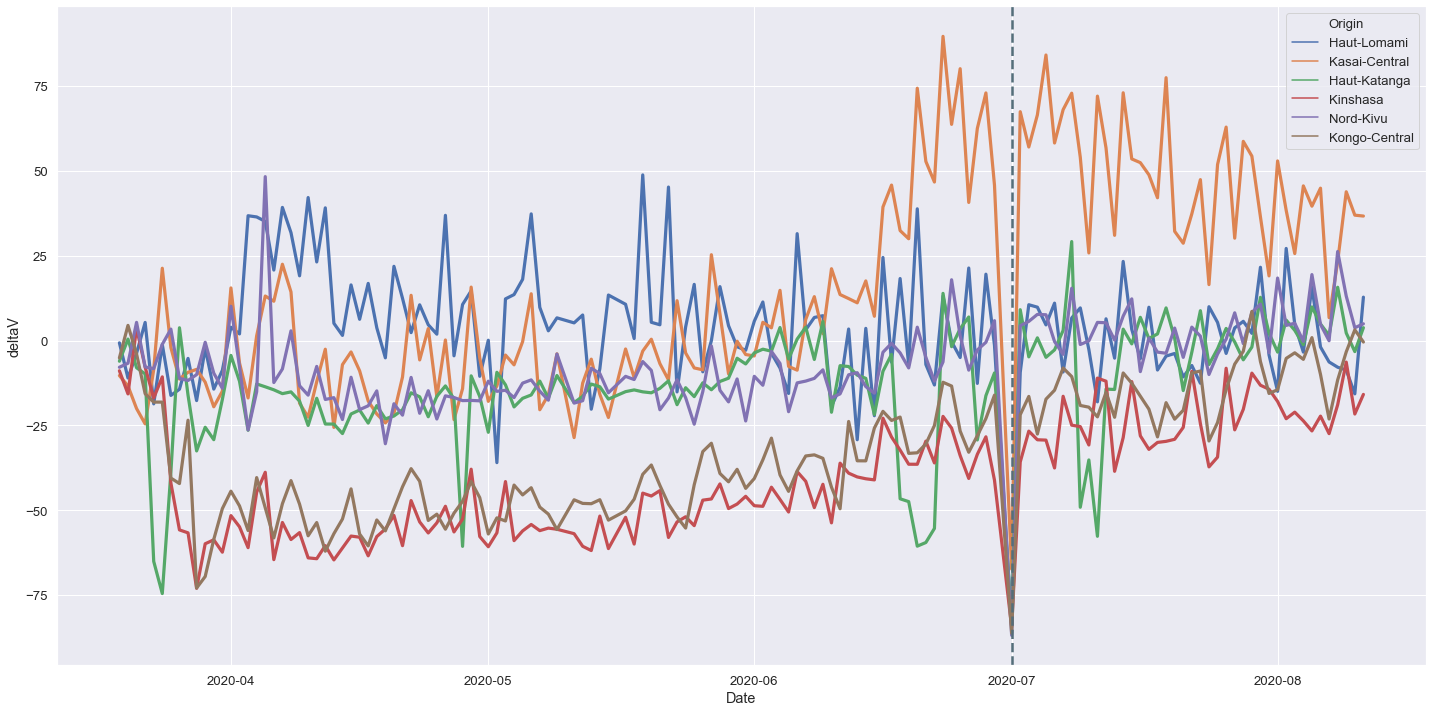

In [162]:
provinces_excluded = ['Bas-Uele',
 'Equateur',
  #'Haut-Katanga',
  #'Haut-Lomami',
 'Haut-Uele',
 'Ituri',
 'Kasai',
 #'Kasai-Central',
 'Kasai-Oriental',
  #'Kinshasa',
  #'Kongo-Central',
 'Kwango',
 'Kwilu',
 'Lomami',
 'Lualaba',
 'Mai-Ndombe',
 'Maniema',
 'Mongala',
  #'Nord-Kivu',
 'Nord-Ubangi',
 'Sankuru',
 'Sud-Kivu',
 'Sud-Ubangi',
 'Tanganyika',
 'Tshopo',
 'Tshuapa']
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x='Date',y='deltaV',data=df_trend[(df_trend.Origin.isin(set(df_trend.Origin)-set(provinces_excluded)))], hue = 'Origin',linewidth = 3.2)

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.

# sns.scatterplot(x='Date',y='Volume',data=df_temp[df_temp.Destination == 'Kinshasa' ], hue = 'Date_type', ax =ax, palette = ['#ffb300','b'])

ax.axvline('2020-07-01',ymin = 0, ymax = 1,color = '#546e7a', ls = '--', linewidth = 2.5)

# ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
# ax.yaxis.set_major_formatter(ticker.EngFormatter())
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)


plt.tight_layout()
plt.show()

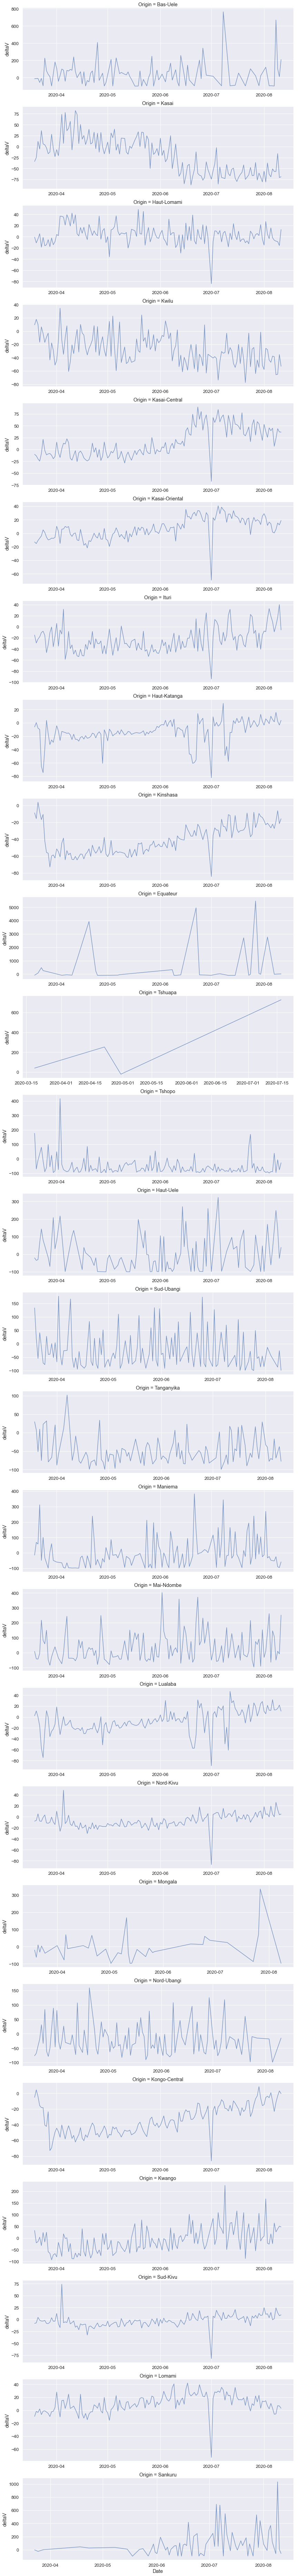

In [163]:
g = sns.FacetGrid(df_trend, row="Origin",aspect=3,height=4,sharey=False,sharex=False)
# g.map(sns.lineplot, x='Date',y='deltaV', alpha=.7)
g.map(plt.plot, "Date", "deltaV", alpha=.7)
# sns.lineplot(x='Date',y='deltaV',data=df_trend)
g.add_legend();

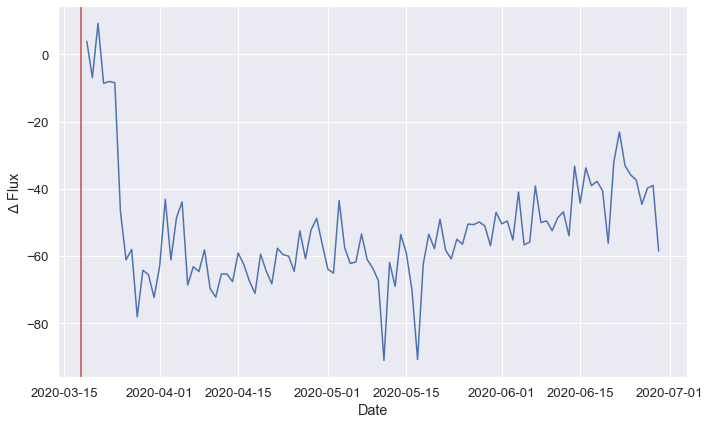

In [91]:
fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(x='Date',y='deltaV',data=df_trend[df_trend.Origin == 'Kinshasa'])

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.
ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = 'r')
ax.set(ylabel = '$\Delta$ Flux')
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)
plt.tight_layout()
plt.show()

# Presence Visualization

In [166]:
# reading csv file
dfp = pd.read_csv('data/new/Zoning Province/Presence_24h.csv',sep = ';')
dfp

Date Day_type PresenceType      Type Activity_Zone  Home_Zone  \
0       2020-02-01       WE         Jour     Local     Hors_Zone  Hors_Zone   
1       2020-02-01       WE         Nuit     Local     Hors_Zone  Hors_Zone   
2       2020-02-01       WE         Jour     Local    Tanganyika  Hors_Zone   
3       2020-02-01       WE         Nuit     Local    Tanganyika  Hors_Zone   
4       2020-02-01       WE         Jour     Local  Haut-Katanga  Hors_Zone   
...            ...      ...          ...       ...           ...        ...   
208455  2020-08-11       JO         Nuit  Etranger     Nord-Kivu  Hors_Zone   
208456  2020-08-11       JO         Jour  Etranger     Hors_Zone  Nord-Kivu   
208457  2020-08-11       JO         Nuit  Etranger     Hors_Zone  Nord-Kivu   
208458  2020-08-11       JO         Jour  Etranger     Nord-Kivu  Nord-Kivu   
208459  2020-08-11       JO         Nuit  Etranger     Nord-Kivu  Nord-Kivu   

              Zone  Volume  
0       Tanganyika  679176  
1       Tanganyika  350111  
2       Tanganyika  770048  
3       Tanganyika  226845  
4       Tanganyika     464  
...            ...     ...  
208455   Nord-Kivu    1209  
208456   Nord-Kivu    1403  
208457   Nord-Kivu    1782  
208458   Nord-Kivu    3835  
208459   Nord-Kivu    3402  

[208460 rows x 8 columns]

In [167]:
dfp.count()

Date             208460
Day_type         208460
PresenceType     208460
Type             208460
Activity_Zone    208460
Home_Zone        208460
Zone             208460
Volume           208460
dtype: int64

In [168]:
# Conversion of date field
dfp['Date'] = pd.to_datetime(dfp['Date'])
# dfp['Date_day'] = dfp['Date'].dt.weekday

In [169]:
list((dfp.groupby(by = 'Day_type').groups.keys()))

['JO', 'WE']

In [170]:
list((dfp.groupby(by = 'PresenceType').groups.keys()))

['Jour', 'Nuit']

In [171]:
list((dfp.groupby(by = 'Type').groups.keys()))

['Etranger', 'Local']

In [172]:
activities_zone = list((dfp.groupby(by = 'Activity_Zone').groups.keys()))
print(activities_zone, len(activities_zone))

['Bas-Uele', 'Equateur', 'Haut-Katanga', 'Haut-Lomami', 'Haut-Uele', 'Hors_Zone', 'Ituri', 'Kasai', 'Kasai-Central', 'Kasai-Oriental', 'Kinshasa', 'Kongo-Central', 'Kwango', 'Kwilu', 'Lomami', 'Lualaba', 'Mai-Ndombe', 'Maniema', 'Mongala', 'Nord-Kivu', 'Nord-Ubangi', 'Sankuru', 'Sud-Kivu', 'Sud-Ubangi', 'Tanganyika', 'Tshopo', 'Tshuapa'] 27


In [173]:
home_zone = list((dfp.groupby(by = 'Home_Zone').groups.keys()))
print(activities_zone, len(activities_zone))

['Bas-Uele', 'Equateur', 'Haut-Katanga', 'Haut-Lomami', 'Haut-Uele', 'Hors_Zone', 'Ituri', 'Kasai', 'Kasai-Central', 'Kasai-Oriental', 'Kinshasa', 'Kongo-Central', 'Kwango', 'Kwilu', 'Lomami', 'Lualaba', 'Mai-Ndombe', 'Maniema', 'Mongala', 'Nord-Kivu', 'Nord-Ubangi', 'Sankuru', 'Sud-Kivu', 'Sud-Ubangi', 'Tanganyika', 'Tshopo', 'Tshuapa'] 27


In [174]:
zone = list((dfp.groupby(by = 'Zone').groups.keys()))
print(activities_zone, len(activities_zone))

['Bas-Uele', 'Equateur', 'Haut-Katanga', 'Haut-Lomami', 'Haut-Uele', 'Hors_Zone', 'Ituri', 'Kasai', 'Kasai-Central', 'Kasai-Oriental', 'Kinshasa', 'Kongo-Central', 'Kwango', 'Kwilu', 'Lomami', 'Lualaba', 'Mai-Ndombe', 'Maniema', 'Mongala', 'Nord-Kivu', 'Nord-Ubangi', 'Sankuru', 'Sud-Kivu', 'Sud-Ubangi', 'Tanganyika', 'Tshopo', 'Tshuapa'] 27


In [175]:
# dfp = dfp[(dfp.Activity_Zone != 'Hors_Zone') | (dfp.Home_Zone != 'Hors_Zone')]
df_dzp = dfp.groupby(["Date","Zone",'PresenceType'],as_index=0).sum()
df_dzp
# df_dzp.groupby(["Zone",'PresenceType'],as_index=0).median()

Date          Zone PresenceType   Volume
0    2020-02-01      Bas-Uele         Jour  1034483
1    2020-02-01      Bas-Uele         Nuit   709632
2    2020-02-01      Equateur         Jour  1803206
3    2020-02-01      Equateur         Nuit  1419771
4    2020-02-01  Haut-Katanga         Jour  5629768
...         ...           ...          ...      ...
9719 2020-08-11    Tanganyika         Nuit  1568133
9720 2020-08-11        Tshopo         Jour  2799508
9721 2020-08-11        Tshopo         Nuit  2125865
9722 2020-08-11       Tshuapa         Jour  1675233
9723 2020-08-11       Tshuapa         Nuit  1102533

[9724 rows x 4 columns]



Let's first consider presence at night

In [176]:
#Aggregate by date and zone
dfp_night = dfp[dfp.PresenceType == 'Jour']
dfp_agg_date_zone = dfp_night.groupby(by=['Date','Zone'],as_index=0).sum()
dfp_agg_date_zone

Date          Zone   Volume
0    2020-02-01      Bas-Uele  1034483
1    2020-02-01      Equateur  1803206
2    2020-02-01  Haut-Katanga  5629768
3    2020-02-01   Haut-Lomami  3289399
4    2020-02-01     Haut-Uele  1539971
...         ...           ...      ...
4857 2020-08-11      Sud-Kivu  6033838
4858 2020-08-11    Sud-Ubangi  2214255
4859 2020-08-11    Tanganyika  2365636
4860 2020-08-11        Tshopo  2799508
4861 2020-08-11       Tshuapa  1675233

[4862 rows x 3 columns]

### Visualization of distributions

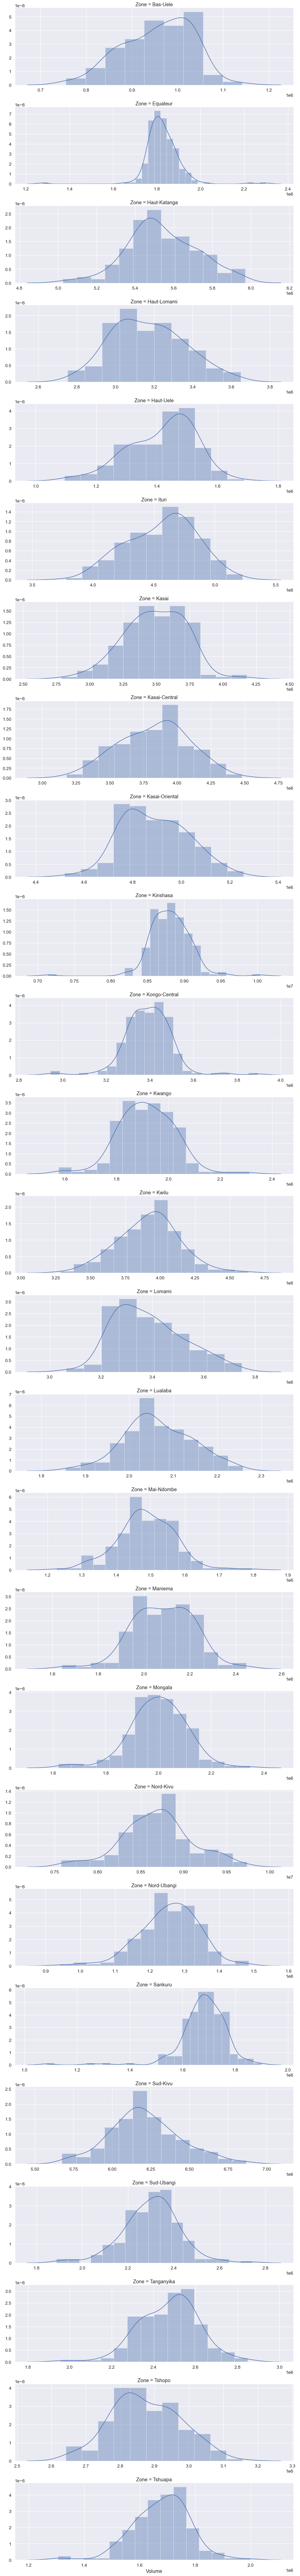

In [177]:
# fig = plt.figure(figsize=(8,5))
# ax = sns.distplot(a=dfp_agg_date_zone[(dfp_agg_date_zone.Zone == 'Kinshasa')]["Volume"])
# ax.set(title = 'Présence',xlabel = "presence",ylabel = '$P(x)$')
# plt.show()

g = sns.FacetGrid(dfp_agg_date_zone, row="Zone",aspect=3,height=4,sharey=False,sharex=False)
# g.map(sns.lineplot, x='Date',y='deltaV', alpha=.7)
g.map(sns.distplot, "Volume")
# sns.lineplot(x='Date',y='deltaV',data=df_trend)
g.add_legend();

In [178]:
dfp_agg_date_zone.groupby(by=['Zone'],as_index=0).median().sort_values(by='Volume')

Zone   Volume
0         Bas-Uele   961963
19     Nord-Ubangi  1264825
4        Haut-Uele  1438408
15      Mai-Ndombe  1482177
25         Tshuapa  1683809
20         Sankuru  1687906
1         Equateur  1817236
11          Kwango  1914386
17         Mongala  2001405
14         Lualaba  2057704
16         Maniema  2080331
22      Sud-Ubangi  2310097
23      Tanganyika  2490911
24          Tshopo  2863566
3      Haut-Lomami  3161731
13          Lomami  3364398
10   Kongo-Central  3394859
6            Kasai  3488908
7    Kasai-Central  3855667
12           Kwilu  3924713
5            Ituri  4614956
8   Kasai-Oriental  4883804
2     Haut-Katanga  5518611
21        Sud-Kivu  6191211
18       Nord-Kivu  8691576
9         Kinshasa  8804125

## Comparison of ref period and obs period

In [179]:
# Date Conversion
dfp_agg_date_zone['Date'] = pd.to_datetime(dfp_agg_date_zone['Date'])
dfp_agg_date_zone['Date_day'] = dfp_agg_date_zone['Date'].dt.weekday

In [180]:
ref_start_date = '2020-02-18'
ref_end_date = '2020-03-18'

mask_base = (dfp_agg_date_zone['Date'] >= ref_start_date) & (dfp_agg_date_zone['Date'] <= ref_end_date)

obs_start_date = '2020-03-19'
obs_end_date = '2020-12-29'

mask_obs = (dfp_agg_date_zone['Date'] >= obs_start_date) & (dfp_agg_date_zone['Date'] <= obs_end_date)

df_ref_p = dfp_agg_date_zone.loc[mask_base]
df_obs_p = dfp_agg_date_zone.loc[mask_obs]

In [181]:
df_ref_p

Date          Zone   Volume  Date_day
416  2020-02-18      Bas-Uele  1021594         1
417  2020-02-18      Equateur  1867714         1
418  2020-02-18  Haut-Katanga  5618657         1
419  2020-02-18   Haut-Lomami  3255188         1
420  2020-02-18     Haut-Uele  1491907         1
...         ...           ...      ...       ...
1139 2020-03-18      Sud-Kivu  6255694         2
1140 2020-03-18    Sud-Ubangi  2326368         2
1141 2020-03-18    Tanganyika  2513528         2
1142 2020-03-18        Tshopo  2923901         2
1143 2020-03-18       Tshuapa  1714441         2

[728 rows x 4 columns]

In [182]:
#data aggregation
df_ref_agg_p = df_ref_p.groupby(by=['Zone'],as_index=0).mean().sort_values(by='Volume',ascending=0)
# df_ref_agg_p.drop('Date_day',inplace=True,axis = 1)

df_obs_agg_p = df_obs_p.groupby(by=['Zone'],as_index=0).mean().sort_values(by='Volume',ascending=0)
# df_obs_agg_p.drop('Date_day',inplace=True,axis = 1)


df_merged_agg_p = pd.merge(df_ref_agg_p,df_obs_agg_p,left_on=['Zone'],right_on=['Zone'])
df_merged_agg_p['deltaVolume'] = (df_merged_agg_p.Volume_y - df_merged_agg_p.Volume_x )/df_merged_agg_p.Volume_x*100
df_merged_agg_p = df_merged_agg_p.sort_values(by='deltaVolume')
df_merged_agg_p

Zone      Volume_x  Date_day_x      Volume_y  Date_day_y  \
25        Bas-Uele  1.030405e+06    2.964286  9.330531e+05    2.986014   
15         Maniema  2.182500e+06    2.964286  2.048881e+06    2.986014   
24     Nord-Ubangi  1.310312e+06    2.964286  1.238651e+06    2.986014   
22      Mai-Ndombe  1.539895e+06    2.964286  1.467377e+06    2.986014   
8            Kasai  3.611292e+06    2.964286  3.445038e+06    2.986014   
20         Tshuapa  1.729399e+06    2.964286  1.659277e+06    2.986014   
14      Sud-Ubangi  2.371461e+06    2.964286  2.279137e+06    2.986014   
5            Ituri  4.702887e+06    2.964286  4.520397e+06    2.986014   
23       Haut-Uele  1.456145e+06    2.964286  1.400718e+06    2.986014   
18          Kwango  1.970282e+06    2.964286  1.895386e+06    2.986014   
11     Haut-Lomami  3.255255e+06    2.964286  3.136943e+06    2.986014   
17         Mongala  2.053233e+06    2.964286  1.980260e+06    2.986014   
0         Kinshasa  9.055815e+06    2.964286  8.743723e+06    2.986014   
13      Tanganyika  2.534033e+06    2.964286  2.454222e+06    2.986014   
9    Kongo-Central  3.465824e+06    2.964286  3.370511e+06    2.986014   
7    Kasai-Central  3.902129e+06    2.964286  3.800182e+06    2.986014   
16         Lualaba  2.107314e+06    2.964286  2.054964e+06    2.986014   
1        Nord-Kivu  8.846975e+06    2.964286  8.633097e+06    2.986014   
3     Haut-Katanga  5.645770e+06    2.964286  5.512440e+06    2.986014   
12          Tshopo  2.920757e+06    2.964286  2.862992e+06    2.986014   
6            Kwilu  3.970570e+06    2.964286  3.894959e+06    2.986014   
21         Sankuru  1.700234e+06    2.964286  1.669786e+06    2.986014   
2         Sud-Kivu  6.297011e+06    2.964286  6.191154e+06    2.986014   
4   Kasai-Oriental  4.930521e+06    2.964286  4.877236e+06    2.986014   
10          Lomami  3.389057e+06    2.964286  3.382001e+06    2.986014   
19        Equateur  1.818622e+06    2.964286  1.829898e+06    2.986014   

    deltaVolume  
25    -9.447937  
15    -6.122307  
24    -5.468992  
22    -4.709291  
8     -4.603720  
20    -4.054666  
14    -3.893107  
5     -3.880393  
23    -3.806391  
18    -3.801296  
11    -3.634507  
17    -3.554074  
0     -3.446314  
13    -3.149572  
9     -2.750068  
7     -2.612584  
16    -2.484173  
1     -2.417528  
3     -2.361594  
12    -1.977752  
6     -1.904291  
21    -1.790835  
2     -1.681062  
4     -1.080710  
10    -0.208205  
19     0.620033

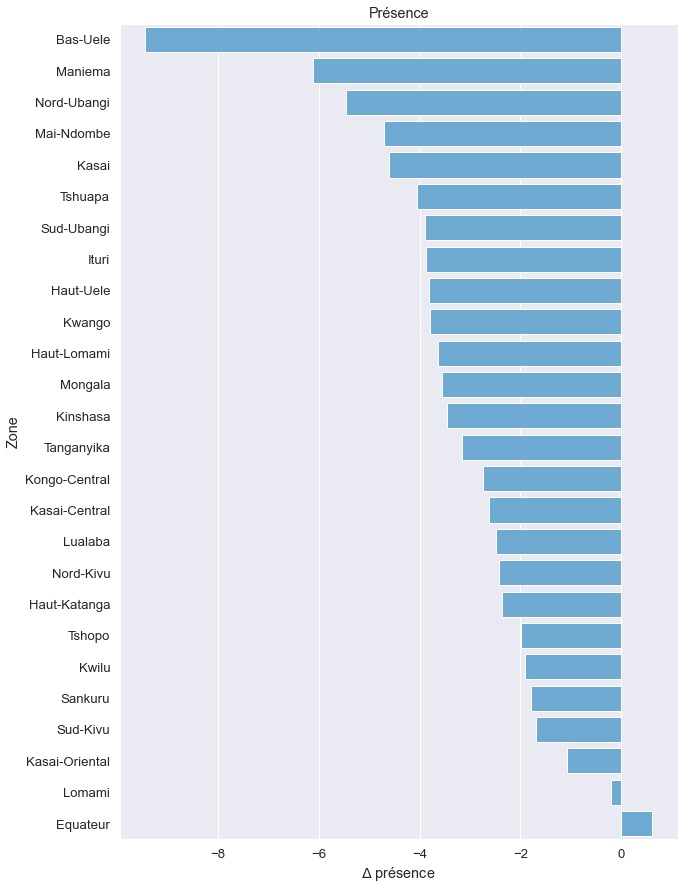

In [183]:
fig = plt.figure(figsize=(10,15))
ax = sns.barplot(y="Zone", x="deltaVolume",palette=['#5DADE2'], data=df_merged_agg_p.sort_values(by='deltaVolume'), orient = 'h')
ax.set(title = 'Présence',xlabel = '$\Delta$ présence')
plt.show()

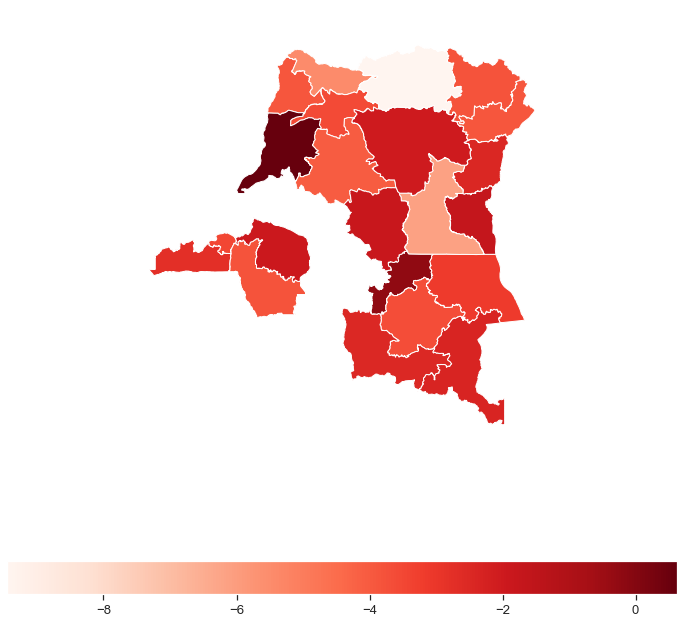

In [184]:
merged_agg_out = zone_gd.merge(df_merged_agg_p,left_on = 'PROVINCE', right_on = 'Zone' )
gpl.choropleth(
    merged_agg_out, hue=merged_agg_out['deltaVolume'],
    cmap='Reds', figsize=(12, 12),
    legend=True
    , legend_kwargs={'orientation': 'horizontal'}
)
plt.show()

### Presence trends By Provinces

In [185]:
df_ref_agg_date_day = df_ref_p.groupby(by=['Date','Zone','Date_day'],as_index=0).sum().groupby(by=['Zone','Date_day'],as_index=0).median()
df_ref_agg_date_day[df_ref_agg_date_day.Zone == 'Kinshasa']

Zone  Date_day     Volume
63  Kinshasa         0  8908974.0
64  Kinshasa         1  8939996.0
65  Kinshasa         2  9031192.0
66  Kinshasa         3  9007938.0
67  Kinshasa         4  9118622.0
68  Kinshasa         5  9158472.5
69  Kinshasa         6  9026253.5

In [186]:
df_obs_agg_date_dest_dd = df_obs_p.groupby(by=['Date','Zone','Date_day'],as_index=0).sum()
df_obs_agg_date_dest_dd[df_obs_agg_date_dest_dd.Zone == 'Kinshasa']

Date      Zone  Date_day   Volume
9    2020-03-19  Kinshasa         3  9169208
35   2020-03-20  Kinshasa         4  8919028
61   2020-03-21  Kinshasa         5  9399123
87   2020-03-22  Kinshasa         6  9547909
113  2020-03-23  Kinshasa         0  9032730
...         ...       ...       ...      ...
3597 2020-08-07  Kinshasa         4  8257663
3623 2020-08-08  Kinshasa         5  8932533
3649 2020-08-09  Kinshasa         6  8763924
3675 2020-08-10  Kinshasa         0  8480426
3701 2020-08-11  Kinshasa         1  8594282

[143 rows x 4 columns]

In [187]:
df_trend = pd.merge(df_obs_agg_date_dest_dd,df_ref_agg_date_day,left_on=['Zone','Date_day'],right_on=['Zone','Date_day']).sort_values(by='Date')
df_trend['deltaV'] = (df_trend['Volume_x'] - df_trend['Volume_y'])/df_trend['Volume_y']*100
# df_trend = df_trend[df_trend.Destination == 'Kinshasa']
df_trend

Date            Zone  Date_day  Volume_x   Volume_y    deltaV
0    2020-03-19        Bas-Uele         3    999295  1038318.5 -3.758336
420  2020-03-19         Sankuru         3   1763487  1708574.0  3.213967
42   2020-03-19    Haut-Katanga         3   5691903  5613758.5  1.392017
441  2020-03-19        Sud-Kivu         3   6290902  6355389.5 -1.014690
273  2020-03-19          Lomami         3   3407999  3390011.5  0.530603
...         ...             ...       ...       ...        ...       ...
3177 2020-08-11          Tshopo         1   2799508  2952165.0 -5.171019
3197 2020-08-11         Tshuapa         1   1675233  1655849.0  1.170638
2737 2020-08-11    Haut-Katanga         1   5405861  5618657.0 -3.787311
2857 2020-08-11  Kasai-Oriental         1   4811803  4826814.0 -0.310992
2757 2020-08-11     Haut-Lomami         1   2973184  3188755.0 -6.760350

[3718 rows x 6 columns]

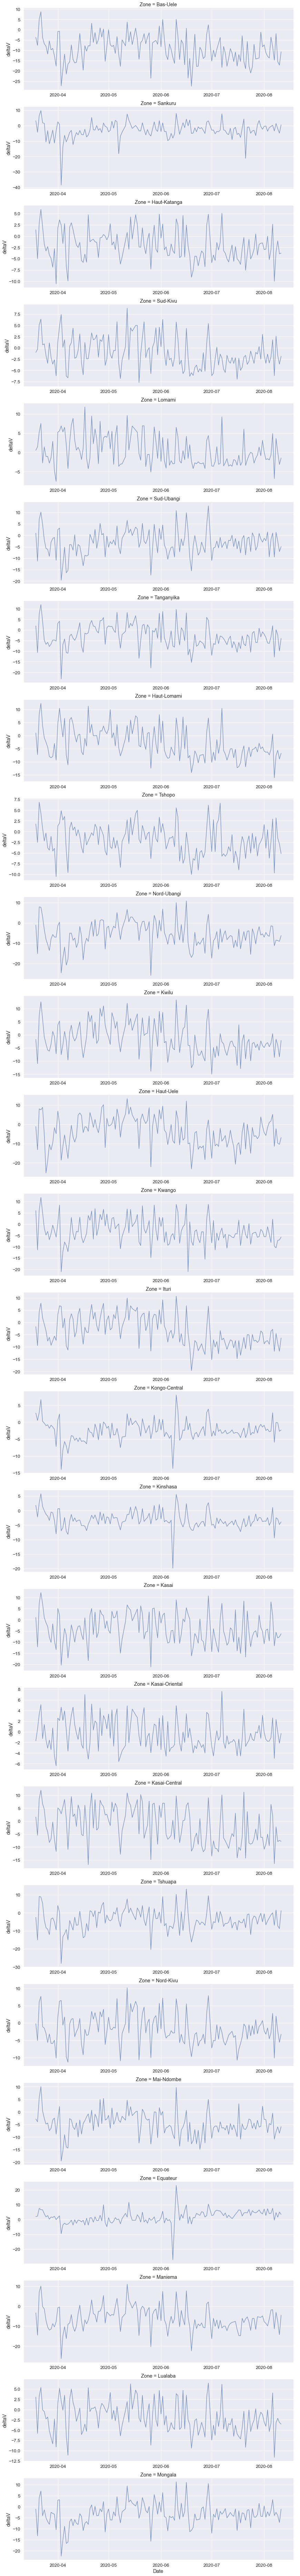

In [188]:
g = sns.FacetGrid(df_trend, row="Zone",aspect=3,height=4,sharey=False,sharex=False)
# g.map(sns.lineplot, x='Date',y='deltaV', alpha=.7)
g.map(plt.plot, "Date", "deltaV", alpha=.7)
# sns.lineplot(x='Date',y='deltaV',data=df_trend)
g.add_legend();

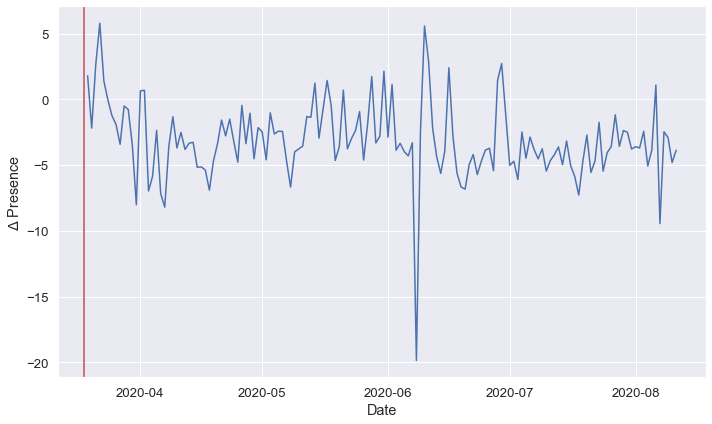

In [189]:
fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(x='Date',y='deltaV',data=df_trend[df_trend.Zone == 'Kinshasa'])

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.
ax.axvline('2020-03-18',ymin = 0, ymax = 1,color = 'r')
ax.set(ylabel = '$\Delta$ Presence')
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)
plt.tight_layout()
plt.show()